In [11]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
import pandas as pd
from matplotlib import pyplot
import seaborn as sns
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pycountry_convert as pc
import folium 
from datetime import datetime
from datetime import timedelta

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
import matplotlib.dates as mdate
pio.templates.default = "plotly_dark"

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

torch.manual_seed(0)
np.random.seed(0)
# torch.cuda.set_device(1)


In [3]:
def error_mse(ty, py):
    mse = mean_squared_error(ty, py)
    return mse

def error_rmsle(ty, py):
    rmsle = np.sqrt(mean_squared_log_error(ty, py))
    return rmsle

def error_mae(ty, py):
    mae = mean_absolute_error(ty, py)
    return mae

def error_mape(ty, py):
    mape = np.mean(np.abs((py - ty) / ty)) 
    return mape

def error_rmse(ty, py):
    mse = mean_squared_error(ty, py)    
    rmse = np.sqrt(mse)
    return rmse

In [34]:
# S is the source sequence length
# T is the target sequence length
# N is the batch size
# E is the feature number

#src = torch.rand((10, 32, 512)) # (S,N,E) 
#tgt = torch.rand((20, 32, 512)) # (T,N,E)
#out = transformer_model(src, tgt)

input_window = 50 # number of input steps
output_window = 1 # number of prediction steps, in this model its fixed to one
batch_size = 100 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]
          
class TransAm(nn.Module):
    def __init__(self,feature_size=250,num_layers=1,dropout=0.05):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

def _log2(data):
    return np.exp(np.exp(data))
    
# if window is 100 and prediction step is 1
# in -> [0..99]
# target -> [1..100]
def create_inout_sequences(input_data, tw, ganData = None):
    inout_seq = []
    inout_seq.extend(create_inout_sequences_front(input_data, tw))
    inout_seq.extend(create_inout_sequences_back(input_data, tw))
    if ganData is not None:
        inout_seq.extend(create_train_sequences(ganData, tw))
    return torch.FloatTensor(inout_seq)

def create_train_sequences(input_data, tw):
    inout_seq = []
    input_data = input_data.reshape(input_data.shape[0], input_data.shape[1])
    for i in range(input_data.shape[0]):
        train_seq = input_data[i][0:tw]
        train_label = input_data[i][1:tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq
    
def create_inout_sequences_front(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+output_window:i+tw+output_window]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

def create_inout_sequences_back(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(tw, L, 1):
        train_seq = input_data[i - tw : i ]
        train_label = input_data[i - tw + output_window : i + output_window]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

def log2_(df):
    df = df[df["confirmed"] >= 3]
    df = df[df["fatalities"] >= 3]
    df["confirmed"] = np.log(np.log(df["confirmed"]))
    df["fatalities"] = np.log(np.log(df["fatalities"]))
    idex = list(range(0, df.shape[0]))
    df["day"] = idex
    return df

def addCsv(df): #累加
    temp_df = df.copy()
#  ->   2021/4/29新加入代码
#     temp_df = temp_df[temp_df["confirmed"] >= 1]
#     temp_df = temp_df[temp_df["fatalities"] >= 1]
#  <-  2021/4/29新加入代码
    confirmed_ = np.array(temp_df['confirmed'].astype(np.float32)).reshape(-1, 1)
    fatalities_ = np.array(temp_df['fatalities'].astype(np.float32)).reshape(-1, 1)
    for i in range(confirmed_.shape[0] - 1):
        confirmed_[i+1] += confirmed_[i]
    for i in range(fatalities_.shape[0] - 1):
        fatalities_[i+1] += fatalities_[i]    
    temp_df['confirmed'] = confirmed_
    temp_df['fatalities'] = fatalities_
    return temp_df

from sklearn.preprocessing import StandardScaler
class DealData:
    def __init__(self, truthName, ganName = None):
        self.scaler = StandardScaler()  #'/home/soul/NewWorkSpace/Informer2020CP/data/ETT/global.csv'
        self.amplitude = pd.read_csv(truthName)
        self.amplitude =  np.array(self.amplitude['confirmed'].astype(np.float32))
        
        self.scaler.fit(self.amplitude.reshape(-1, 1))
        self.amplitude = self.scaler.transform(self.amplitude.reshape(-1, 1)).reshape(-1)
        #         _del30_confirmed_SJ_noise_61_1000
        #/home/soul/NewWorkSpace/Covid_2021_4_18/ganData/stand_global_+_del30_confirmed_noise_61_1000.npy
        if ganName is not None:
            self.trainData = np.load(ganName)
        else:
            self.trainData = None
        
    def trainTestData(self):
        train_sampels = -30
        test_samples = -80
        train_data = self.amplitude[:train_sampels]
        test_data = self.amplitude[test_samples:]

        train_sequence = create_inout_sequences(train_data, input_window, self.trainData)
        test_sequenc = create_inout_sequences(test_data, input_window)
        
        return train_sequence.to(device),test_sequenc.to(device)
    
    def train_data(self):
        train_sequence = create_train_sequences(self.trainData, input_window, self.trainData)
        return train_sequence.to(device)
    
    def trainPredictData(self):
        self.trainData = np.load("/home/soul/NewWorkSpace/Covid_2021_4_18/ganData/stand_global_+_confirmed_noise_61_1000.npy")
        train_data = self.amplitude
        train_sequence = create_inout_sequences(train_data, input_window, self.trainData)
        return train_sequence.to(device)
    
    def get_plot_data(self, eval_model):
        eval_model.eval() 
        test_result = torch.Tensor(0)    
        truth = torch.Tensor(0)
        
        temp_data = torch.FloatTensor(self.amplitude[0:input_window])
        test_result = torch.cat((test_result, temp_data), 0)
        truth = torch.cat((truth, temp_data), 0)
        
        data_source = torch.FloatTensor(create_inout_sequences_back(self.amplitude, input_window)).to(device)
        with torch.no_grad():
            for i in range(0, len(data_source)):
                data, target = get_batch(data_source, i,1)
                output = eval_model(data)    
                test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0)
                truth = torch.cat((truth, target[-1].view(-1).cpu()), 0)
                
            mse   = error_mse(truth[-30:], test_result[-30:])
            rmsle = error_rmsle(truth[-30:], test_result[-30:])
            mae   = error_mae(truth[-30:], test_result[-30:])
            mape  = error_mape(truth[-30:].numpy(), test_result[-30:].numpy())
            rmse  = error_rmse(truth[-30:], test_result[-30:])
                
        print(len(test_result), len(truth))
        truth = self.scaler.inverse_transform(truth)
        test_result = self.scaler.inverse_transform(test_result)
        return mse, rmsle, mae, mape, rmse, truth, test_result
    
    def plot_and_loss(self, eval_model,epoch, test = False):
        eval_model.eval() 
        total_loss = 0.
        test_result = torch.Tensor(0)    
        truth = torch.Tensor(0)
        
        temp_data = torch.FloatTensor(self.amplitude[0:input_window])
        test_result = torch.cat((test_result, temp_data), 0)
        truth = torch.cat((truth, temp_data), 0)
        
        data_source = torch.FloatTensor(create_inout_sequences_back(self.amplitude, input_window)).to(device)
        with torch.no_grad():
            for i in range(0, len(data_source)):
                data, target = get_batch(data_source, i,1)
                output = eval_model(data)    
                test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0)
                truth = torch.cat((truth, target[-1].view(-1).cpu()), 0)
                
            mse = criterion(truth[-30:], test_result[-30:]).cpu().item() 
            rmsle = error_rmsle(truth[-30:], test_result[-30:])
        
            if test == False:
                temp_truth = truth
                for t in range(0, 30):
                    data = np.array(temp_truth[-input_window:]).reshape([input_window, 1, 1]).astype(np.float32)
                    output = eval_model(torch.FloatTensor(data).to(device))   
                    temp_truth = torch.cat((temp_truth, output[-1].view(-1).cpu()), 0)
                    test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0)
                
        print(len(test_result), len(truth))
        truth = self.scaler.inverse_transform(truth)
        test_result = self.scaler.inverse_transform(test_result)
        
        fig = pyplot.figure(figsize=[20, 10])
        pyplot.title('Global Confirmed Data')
        pyplot.plot(truth[-100:], color='blue', marker='o')
        pyplot.plot(truth[-100:],color="blue", label = 'Measured')
        
        if test == False:
            pyplot.plot(test_result[-130:], color='green', marker='o')
            pyplot.plot(test_result[-130:], color="green", label = 'Predicted')

            pyplot.plot(test_result[-130:-30], color='red', marker='o')
            pyplot.plot(test_result[-130:-30], color="red", label = 'Predicted')        
        else:
            pyplot.plot(test_result[-100:], color='green', marker='o')
            pyplot.plot(test_result[-100:], color="green", label = 'Predicted')

            pyplot.plot(test_result[-100:-30], color='red', marker='o')
            pyplot.plot(test_result[-100:-30], color="red", label = 'Predicted')
        pyplot.show()
        pyplot.close()
        
        
        pyplot.title('Global Confirmed Data')
        pyplot.plot(test_result,color="green", label = 'Predicted')
        pyplot.plot(test_result[:-30],color="red", label = 'Predicted')
        pyplot.plot(truth,color="blue", label = 'Measured')
        pyplot.grid(True)
        pyplot.legend(loc='best')
    #     pyplot.savefig('graph/transformer-epoch%d.png'%epoch)
        pyplot.show()
        pyplot.close()
        
        return mse, rmsle


def get_batch(source, i,batch_size):
    seq_len = min(batch_size, len(source) - i) #len(source) - 1 - i
    data = source[i:i+seq_len]    
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window,1)) # 1 is feature size
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window,1))
    return input, target


def train(train_data):
    model.train() # Turn on the train mode \o/
    total_loss = 0.
    start_time = time.time()
    a = output_window / input_window
    b = 1 - a
    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
#         loss = criterion(output[-output_window:], targets[-output_window:])
#         loss =  a * criterion(output[:-output_window], targets[:-output_window]) + b * criterion(output[-output_window:], targets[-output_window:])
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 10
    with torch.no_grad():
        for i in range(0, len(data_source) - 1):
            data, targets = get_batch(data_source, i,eval_batch_size)
            output = eval_model(data)            
            total_loss += criterion(output[-output_window:], targets[-output_window:]).cpu().item()
    return total_loss / len(data_source)


def saveModel(model, name):
    # 保存
    torch.save(model.state_dict(), './saveModel/' + name + '.pkl')

def loadModel(model, name):
    # 加载
    model.load_state_dict(torch.load('./saveModel/' + name + '.pkl', map_location='cuda:0'))
    return model


def save_epoch_data(epochs = 20):
    df = pd.DataFrame()
    df['X'] = []
    df['Y'] = []
    
    frames = []
    for i in range(epochs):
        model = TransAm().to(device)
        model = loadModel(model, "parameter_global_confirmed_50sq_del30_changeLoss_noise_" + str(i) + "_best")
        dealData = DealData()
        truths, predicts = dealData.get_plot_data(model)
    
        temp_df = pd.DataFrame()
        temp_df['X'] = range(len(predicts))
        temp_df['Y'] = predicts
        
        frames.append(temp_df)
        
    result = pd.concat(frames)
    result.to_csv("epoch_data_changLoss_noise_20.csv")

    
def plog_epoch_image(epochs = 20):
    
    df = pd.read_csv("epoch_data_changLoss_noise_20.csv")

    sns.lineplot(x="X", y="Y",color="red", ci="sd", data=df)
    
#     plt.plot(serise, truth[-100:], color='purple', marker='o')
#     plt.plot(serise, truth[-100:],color="purple", label = 'Reported')

#     plt.plot(serise, predict[-100:], color='orange', marker='o')
#     plt.plot(serise, predict[-100:], color="orange", label = 'Projection')

#     plt.plot(serise, predict[-100:-30], color='crimson', marker='o')
#     plt.plot(serise, predict[-100:-30], color="crimson", label = 'Fitting')

def plot_image(truth, predict, start = '2020-01-22', end = '2021-04-25', title = 'Global Confirmed Data', isSave = False):
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(1,1,1)
    ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))#设置时间标签显示格式
    serise= pd.date_range(start, end)
    plt.xticks(pd.date_range(start, end, freq='30d'),rotation=45)
    plt.title(title)
    
    plt.plot(serise, truth,color="purple", label = 'Reported')
    plt.plot(serise, predict, color="orange", label = 'Projection')
    plt.plot(serise[:-30], predict[:-30], color="crimson", label = 'Fitting')
    plt.grid(True, which='both')
    
    if isSave == True:
        plt.savefig('./image/' + title)
    plt.show()


In [24]:
dealData = DealData("/home/soul/NewWorkSpace/Covid_2021_4_18/data/global.csv",
                        "/home/soul/NewWorkSpace/Covid_2021_4_18/ganDataNew/stand_global_del30_confirmed_noise_1000_everyday.npy")
train_data, val_data = dealData.trainTestData()
print(train_data.shape, val_data.shape) 

torch.Size([1760, 2, 50]) torch.Size([60, 2, 50])


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch   1 |     1/    7 batches | lr 0.005000 | 61.68 ms | loss 160.73758 | ppl 6418633897511750638341582348044447653171960186486870530575764549533696.00
| epoch   1 |     2/    7 batches | lr 0.005000 | 26.53 ms | loss 101.76038 | ppl 156305074014822100858161182249110612540915712.00
| epoch   1 |     3/    7 batches | lr 0.005000 | 25.26 ms | loss 15.23640 | ppl 4140788.51
| epoch   1 |     4/    7 batches | lr 0.005000 | 25.41 ms | loss 37.61811 | ppl 21744004764460428.00
| epoch   1 |     5/    7 batches | lr 0.005000 | 26.75 ms | loss 10.94405 | ppl 56616.11
| epoch   1 |     6/    7 batches | lr 0.005000 | 26.52 ms | loss 14.00220 | ppl 1205248.48
| epoch   1 |     7/    7 batches | lr 0.005000 | 26.40 ms | loss 6.43195 | ppl   621.39
| epoch   2 |     1/    7 batches | lr 0.004513 | 54.21 ms | loss 7.22630 | ppl  1375.12
| epoch   2 |     2/    7 batches | lr 0.004513 | 25.45 ms | loss 1.57993 | ppl     4.85
| epoch   2 |     3/    7 batches | lr 0.004513 | 26.83 ms | loss 1.41

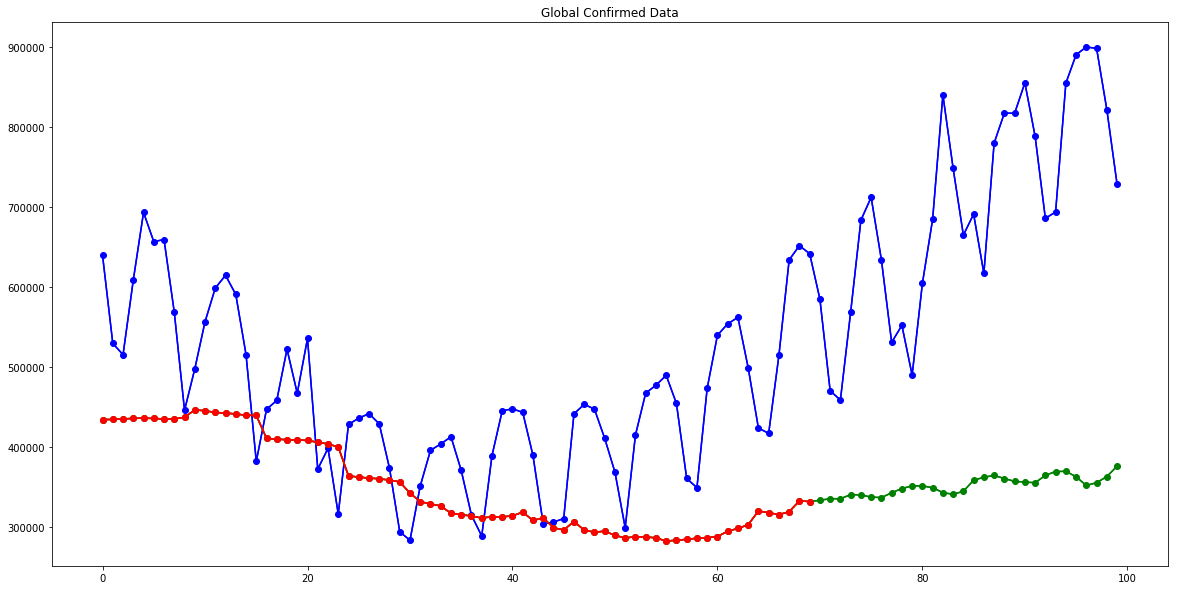

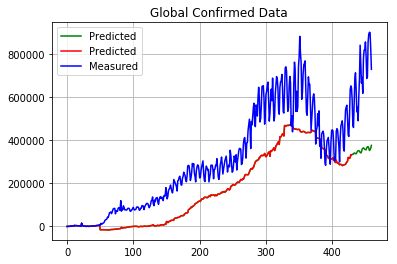

-----------------------------------------------------------------------------------------
| end of epoch  10 | time:  3.01s | mse loss 2.42023 | rmsle loss 0.82942 
-----------------------------------------------------------------------------------------
| epoch  11 |     1/    7 batches | lr 0.002844 | 66.60 ms | loss 0.24100 | ppl     1.27
| epoch  11 |     2/    7 batches | lr 0.002844 | 32.60 ms | loss 0.23439 | ppl     1.26
| epoch  11 |     3/    7 batches | lr 0.002844 | 32.66 ms | loss 0.22016 | ppl     1.25
| epoch  11 |     4/    7 batches | lr 0.002844 | 32.29 ms | loss 0.11075 | ppl     1.12
| epoch  11 |     5/    7 batches | lr 0.002844 | 32.67 ms | loss 0.08558 | ppl     1.09


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch  11 |     6/    7 batches | lr 0.002844 | 32.44 ms | loss 0.21296 | ppl     1.24
| epoch  11 |     7/    7 batches | lr 0.002844 | 30.59 ms | loss 0.46167 | ppl     1.59
| epoch  12 |     1/    7 batches | lr 0.002702 | 65.19 ms | loss 0.15127 | ppl     1.16
| epoch  12 |     2/    7 batches | lr 0.002702 | 35.34 ms | loss 0.09351 | ppl     1.10
| epoch  12 |     3/    7 batches | lr 0.002702 | 33.24 ms | loss 0.17618 | ppl     1.19
| epoch  12 |     4/    7 batches | lr 0.002702 | 36.67 ms | loss 0.05405 | ppl     1.06
| epoch  12 |     5/    7 batches | lr 0.002702 | 30.94 ms | loss 0.15946 | ppl     1.17
| epoch  12 |     6/    7 batches | lr 0.002702 | 38.25 ms | loss 0.28399 | ppl     1.33
| epoch  12 |     7/    7 batches | lr 0.002702 | 34.19 ms | loss 0.24483 | ppl     1.28
| epoch  13 |     1/    7 batches | lr 0.002567 | 66.12 ms | loss 0.06201 | ppl     1.06
| epoch  13 |     2/    7 batches | lr 0.002567 | 37.04 ms | loss 0.09404 | ppl     1.10
| epoch  13 |     3/ 

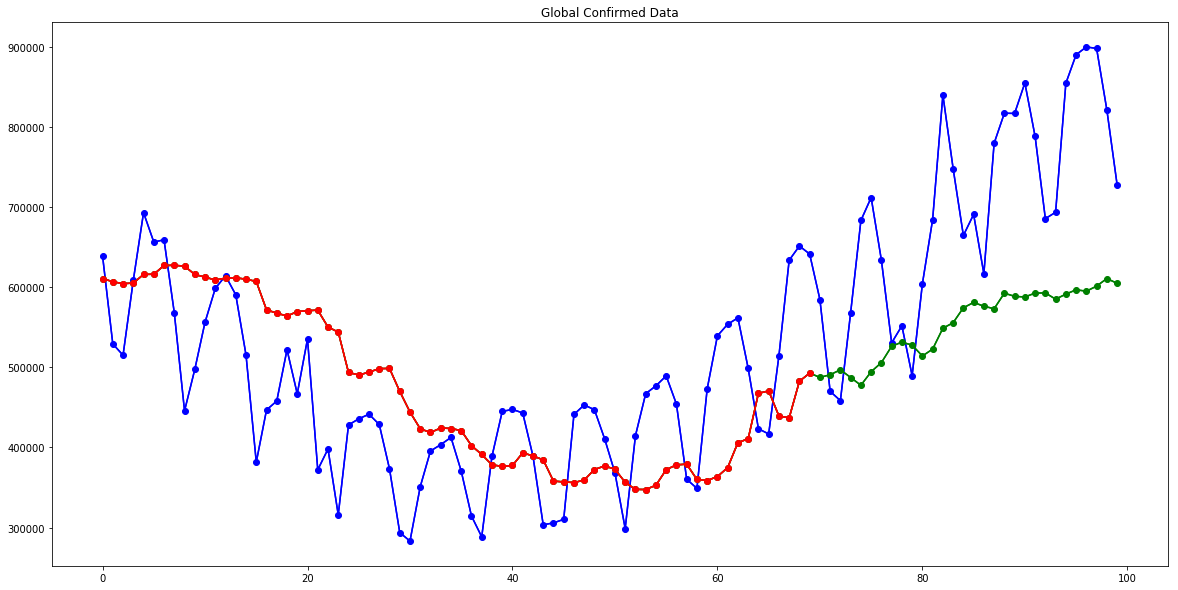

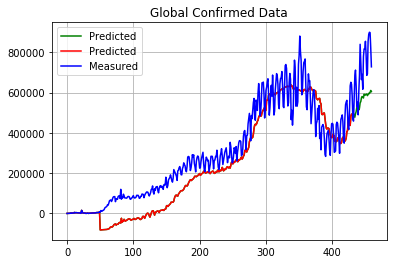

-----------------------------------------------------------------------------------------
| end of epoch  20 | time:  3.84s | mse loss 0.56959 | rmsle loss 0.30331 
-----------------------------------------------------------------------------------------
| epoch  21 |     1/    7 batches | lr 0.001703 | 59.23 ms | loss 0.24386 | ppl     1.28
| epoch  21 |     2/    7 batches | lr 0.001703 | 30.22 ms | loss 0.08541 | ppl     1.09
| epoch  21 |     3/    7 batches | lr 0.001703 | 30.26 ms | loss 0.17191 | ppl     1.19
| epoch  21 |     4/    7 batches | lr 0.001703 | 30.00 ms | loss 0.02829 | ppl     1.03
| epoch  21 |     5/    7 batches | lr 0.001703 | 30.09 ms | loss 0.01847 | ppl     1.02


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch  21 |     6/    7 batches | lr 0.001703 | 30.15 ms | loss 0.09440 | ppl     1.10
| epoch  21 |     7/    7 batches | lr 0.001703 | 27.70 ms | loss 0.15274 | ppl     1.17
| epoch  22 |     1/    7 batches | lr 0.001618 | 60.22 ms | loss 0.02841 | ppl     1.03
| epoch  22 |     2/    7 batches | lr 0.001618 | 30.46 ms | loss 0.12942 | ppl     1.14
| epoch  22 |     3/    7 batches | lr 0.001618 | 30.45 ms | loss 0.22214 | ppl     1.25
| epoch  22 |     4/    7 batches | lr 0.001618 | 30.43 ms | loss 0.01838 | ppl     1.02
| epoch  22 |     5/    7 batches | lr 0.001618 | 27.87 ms | loss 0.01390 | ppl     1.01
| epoch  22 |     6/    7 batches | lr 0.001618 | 24.57 ms | loss 0.15716 | ppl     1.17
| epoch  22 |     7/    7 batches | lr 0.001618 | 23.51 ms | loss 0.17573 | ppl     1.19
| epoch  23 |     1/    7 batches | lr 0.001537 | 47.94 ms | loss 0.02237 | ppl     1.02
| epoch  23 |     2/    7 batches | lr 0.001537 | 24.21 ms | loss 0.05936 | ppl     1.06
| epoch  23 |     3/ 

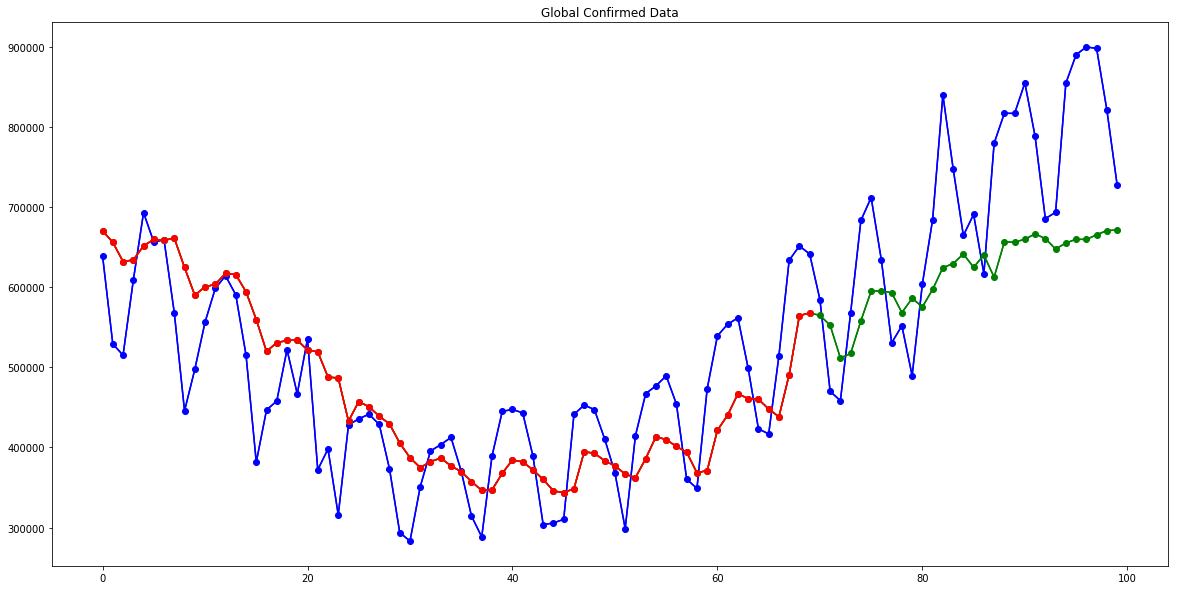

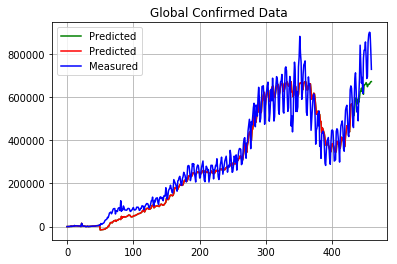

-----------------------------------------------------------------------------------------
| end of epoch  30 | time:  4.19s | mse loss 0.29045 | rmsle loss 0.20314 
-----------------------------------------------------------------------------------------
| epoch  31 |     1/    7 batches | lr 0.001020 | 54.09 ms | loss 0.01848 | ppl     1.02
| epoch  31 |     2/    7 batches | lr 0.001020 | 31.23 ms | loss 0.05336 | ppl     1.05
| epoch  31 |     3/    7 batches | lr 0.001020 | 25.64 ms | loss 0.10620 | ppl     1.11
| epoch  31 |     4/    7 batches | lr 0.001020 | 26.51 ms | loss 0.00749 | ppl     1.01
| epoch  31 |     5/    7 batches | lr 0.001020 | 25.59 ms | loss 0.01333 | ppl     1.01
| epoch  31 |     6/    7 batches | lr 0.001020 | 29.10 ms | loss 0.08910 | ppl     1.09


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch  31 |     7/    7 batches | lr 0.001020 | 28.08 ms | loss 0.12445 | ppl     1.13
| epoch  32 |     1/    7 batches | lr 0.000969 | 49.99 ms | loss 0.01911 | ppl     1.02
| epoch  32 |     2/    7 batches | lr 0.000969 | 25.02 ms | loss 0.07189 | ppl     1.07
| epoch  32 |     3/    7 batches | lr 0.000969 | 24.69 ms | loss 0.12157 | ppl     1.13
| epoch  32 |     4/    7 batches | lr 0.000969 | 23.81 ms | loss 0.00539 | ppl     1.01
| epoch  32 |     5/    7 batches | lr 0.000969 | 23.85 ms | loss 0.01282 | ppl     1.01
| epoch  32 |     6/    7 batches | lr 0.000969 | 23.83 ms | loss 0.07965 | ppl     1.08
| epoch  32 |     7/    7 batches | lr 0.000969 | 23.02 ms | loss 0.11874 | ppl     1.13
| epoch  33 |     1/    7 batches | lr 0.000920 | 49.24 ms | loss 0.01674 | ppl     1.02
| epoch  33 |     2/    7 batches | lr 0.000920 | 24.72 ms | loss 0.05097 | ppl     1.05
| epoch  33 |     3/    7 batches | lr 0.000920 | 23.69 ms | loss 0.10078 | ppl     1.11
| epoch  33 |     4/ 

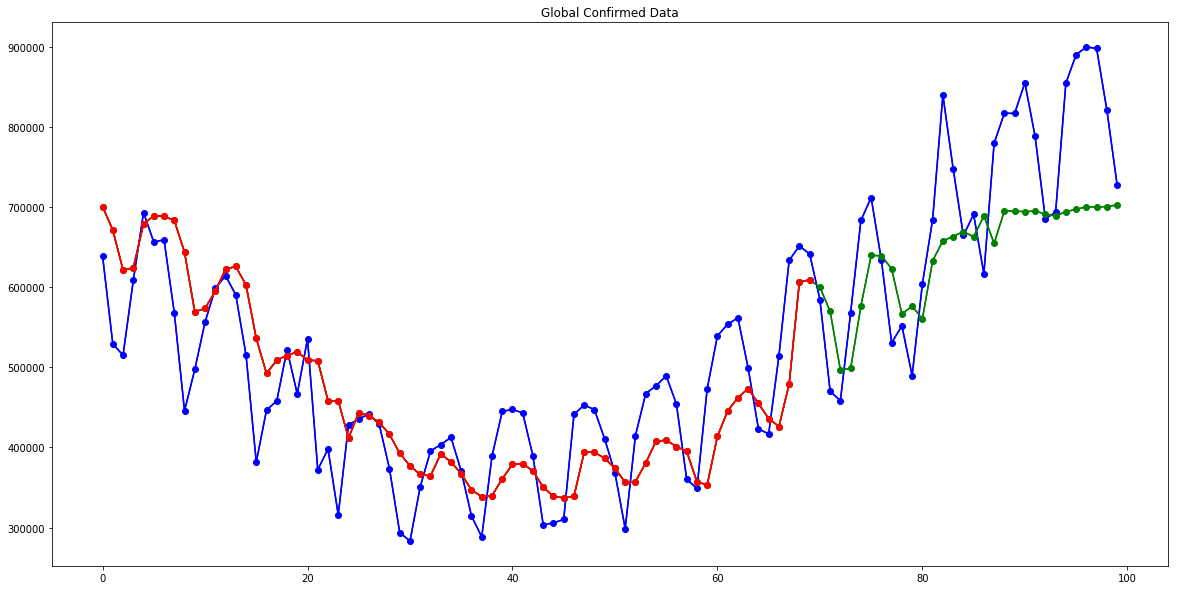

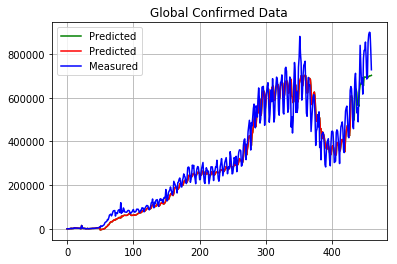

-----------------------------------------------------------------------------------------
| end of epoch  40 | time:  3.06s | mse loss 0.19713 | rmsle loss 0.16633 
-----------------------------------------------------------------------------------------
| epoch  41 |     1/    7 batches | lr 0.000610 | 59.44 ms | loss 0.01466 | ppl     1.01
| epoch  41 |     2/    7 batches | lr 0.000610 | 25.44 ms | loss 0.05249 | ppl     1.05
| epoch  41 |     3/    7 batches | lr 0.000610 | 24.87 ms | loss 0.09733 | ppl     1.10
| epoch  41 |     4/    7 batches | lr 0.000610 | 26.04 ms | loss 0.00625 | ppl     1.01
| epoch  41 |     5/    7 batches | lr 0.000610 | 29.41 ms | loss 0.01472 | ppl     1.01
| epoch  41 |     6/    7 batches | lr 0.000610 | 33.02 ms | loss 0.07535 | ppl     1.08


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch  41 |     7/    7 batches | lr 0.000610 | 30.64 ms | loss 0.11232 | ppl     1.12
| epoch  42 |     1/    7 batches | lr 0.000580 | 55.41 ms | loss 0.01635 | ppl     1.02
| epoch  42 |     2/    7 batches | lr 0.000580 | 25.03 ms | loss 0.05275 | ppl     1.05
| epoch  42 |     3/    7 batches | lr 0.000580 | 25.12 ms | loss 0.09910 | ppl     1.10
| epoch  42 |     4/    7 batches | lr 0.000580 | 28.34 ms | loss 0.00576 | ppl     1.01
| epoch  42 |     5/    7 batches | lr 0.000580 | 38.44 ms | loss 0.01428 | ppl     1.01
| epoch  42 |     6/    7 batches | lr 0.000580 | 36.18 ms | loss 0.07412 | ppl     1.08
| epoch  42 |     7/    7 batches | lr 0.000580 | 28.37 ms | loss 0.10849 | ppl     1.11
| epoch  43 |     1/    7 batches | lr 0.000551 | 70.83 ms | loss 0.01437 | ppl     1.01
| epoch  43 |     2/    7 batches | lr 0.000551 | 34.48 ms | loss 0.05377 | ppl     1.06
| epoch  43 |     3/    7 batches | lr 0.000551 | 30.75 ms | loss 0.09646 | ppl     1.10
| epoch  43 |     4/ 

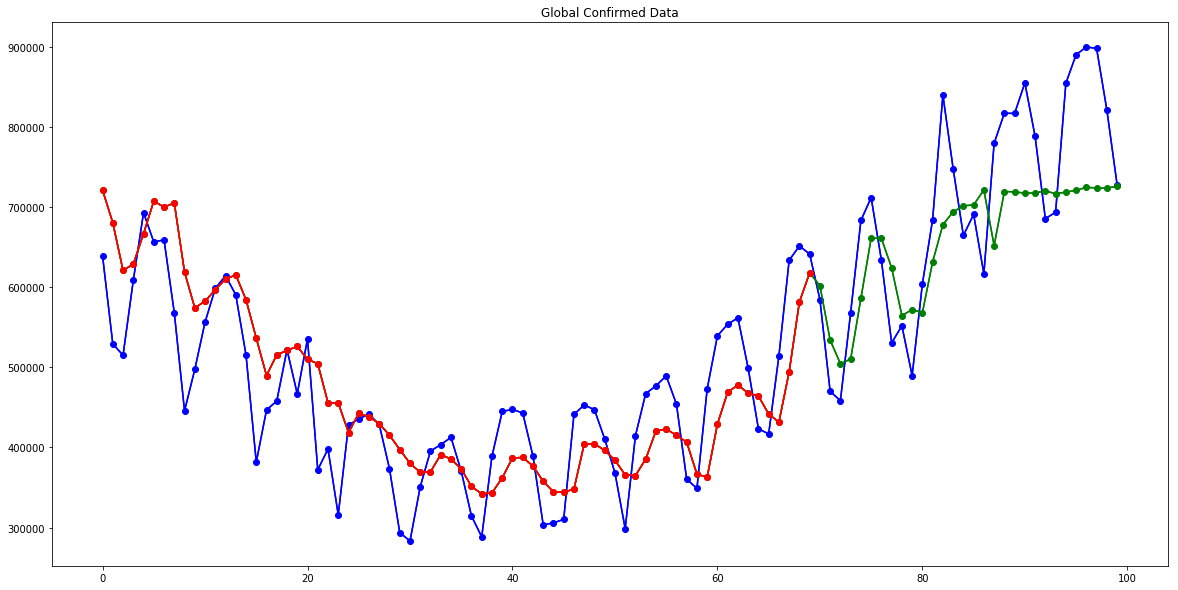

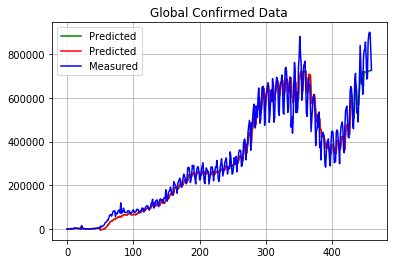

-----------------------------------------------------------------------------------------
| end of epoch  50 | time:  3.24s | mse loss 0.15367 | rmsle loss 0.14588 
-----------------------------------------------------------------------------------------
| epoch  51 |     1/    7 batches | lr 0.000365 | 47.13 ms | loss 0.01309 | ppl     1.01
| epoch  51 |     2/    7 batches | lr 0.000365 | 23.46 ms | loss 0.04883 | ppl     1.05
| epoch  51 |     3/    7 batches | lr 0.000365 | 23.65 ms | loss 0.09044 | ppl     1.09
| epoch  51 |     4/    7 batches | lr 0.000365 | 24.56 ms | loss 0.00468 | ppl     1.00
| epoch  51 |     5/    7 batches | lr 0.000365 | 23.56 ms | loss 0.01215 | ppl     1.01
| epoch  51 |     6/    7 batches | lr 0.000365 | 24.51 ms | loss 0.07342 | ppl     1.08
| epoch  51 |     7/    7 batches | lr 0.000365 | 23.55 ms | loss 0.10574 | ppl     1.11


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch  52 |     1/    7 batches | lr 0.000347 | 49.00 ms | loss 0.01468 | ppl     1.01
| epoch  52 |     2/    7 batches | lr 0.000347 | 24.69 ms | loss 0.04939 | ppl     1.05
| epoch  52 |     3/    7 batches | lr 0.000347 | 24.57 ms | loss 0.08980 | ppl     1.09
| epoch  52 |     4/    7 batches | lr 0.000347 | 23.62 ms | loss 0.00407 | ppl     1.00
| epoch  52 |     5/    7 batches | lr 0.000347 | 23.69 ms | loss 0.01212 | ppl     1.01
| epoch  52 |     6/    7 batches | lr 0.000347 | 24.59 ms | loss 0.07224 | ppl     1.07
| epoch  52 |     7/    7 batches | lr 0.000347 | 22.63 ms | loss 0.10586 | ppl     1.11
| epoch  53 |     1/    7 batches | lr 0.000330 | 47.21 ms | loss 0.01324 | ppl     1.01
| epoch  53 |     2/    7 batches | lr 0.000330 | 24.32 ms | loss 0.04813 | ppl     1.05
| epoch  53 |     3/    7 batches | lr 0.000330 | 23.67 ms | loss 0.08970 | ppl     1.09
| epoch  53 |     4/    7 batches | lr 0.000330 | 23.59 ms | loss 0.00389 | ppl     1.00
| epoch  53 |     5/ 

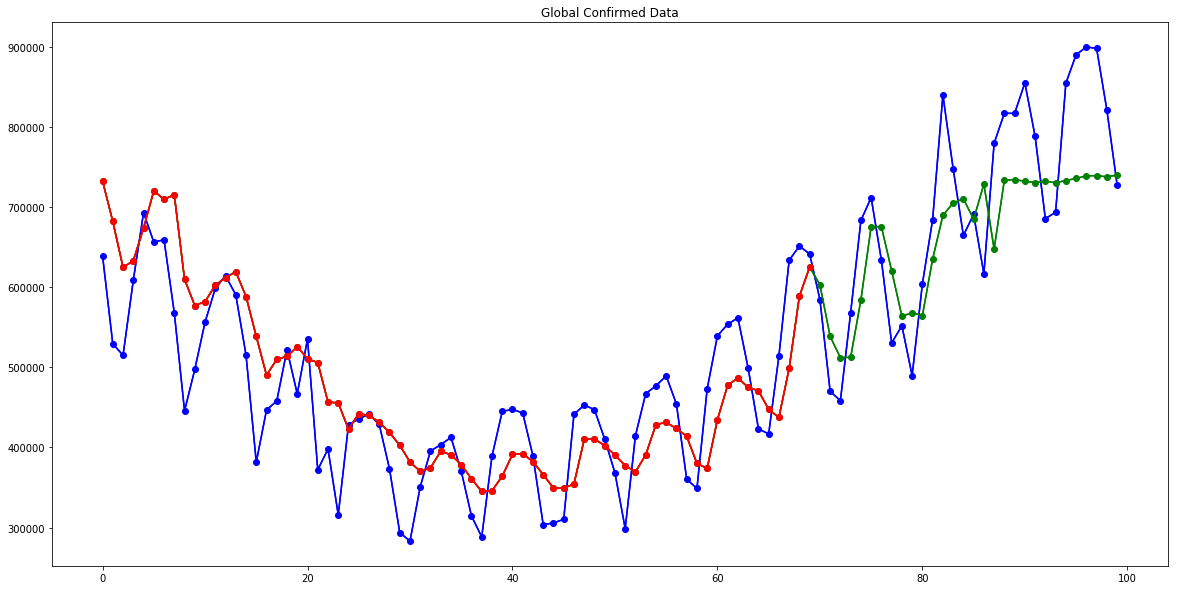

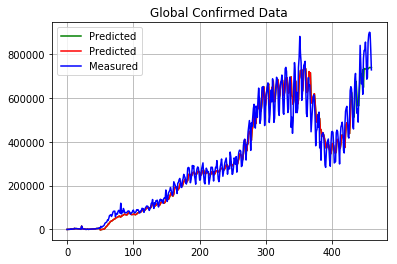

-----------------------------------------------------------------------------------------
| end of epoch  60 | time:  3.89s | mse loss 0.13521 | rmsle loss 0.13820 
-----------------------------------------------------------------------------------------
| epoch  61 |     1/    7 batches | lr 0.000219 | 59.35 ms | loss 0.01301 | ppl     1.01
| epoch  61 |     2/    7 batches | lr 0.000219 | 29.05 ms | loss 0.04716 | ppl     1.05
| epoch  61 |     3/    7 batches | lr 0.000219 | 29.07 ms | loss 0.08638 | ppl     1.09
| epoch  61 |     4/    7 batches | lr 0.000219 | 29.07 ms | loss 0.00386 | ppl     1.00
| epoch  61 |     5/    7 batches | lr 0.000219 | 29.13 ms | loss 0.01178 | ppl     1.01


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch  61 |     6/    7 batches | lr 0.000219 | 29.83 ms | loss 0.07068 | ppl     1.07
| epoch  61 |     7/    7 batches | lr 0.000219 | 27.93 ms | loss 0.10011 | ppl     1.11
| epoch  62 |     1/    7 batches | lr 0.000208 | 59.77 ms | loss 0.01312 | ppl     1.01
| epoch  62 |     2/    7 batches | lr 0.000208 | 29.24 ms | loss 0.04706 | ppl     1.05
| epoch  62 |     3/    7 batches | lr 0.000208 | 29.18 ms | loss 0.08724 | ppl     1.09
| epoch  62 |     4/    7 batches | lr 0.000208 | 29.15 ms | loss 0.00388 | ppl     1.00
| epoch  62 |     5/    7 batches | lr 0.000208 | 30.21 ms | loss 0.01178 | ppl     1.01
| epoch  62 |     6/    7 batches | lr 0.000208 | 34.78 ms | loss 0.06893 | ppl     1.07
| epoch  62 |     7/    7 batches | lr 0.000208 | 27.82 ms | loss 0.10138 | ppl     1.11
| epoch  63 |     1/    7 batches | lr 0.000197 | 58.11 ms | loss 0.01301 | ppl     1.01
| epoch  63 |     2/    7 batches | lr 0.000197 | 29.19 ms | loss 0.04666 | ppl     1.05
| epoch  63 |     3/ 

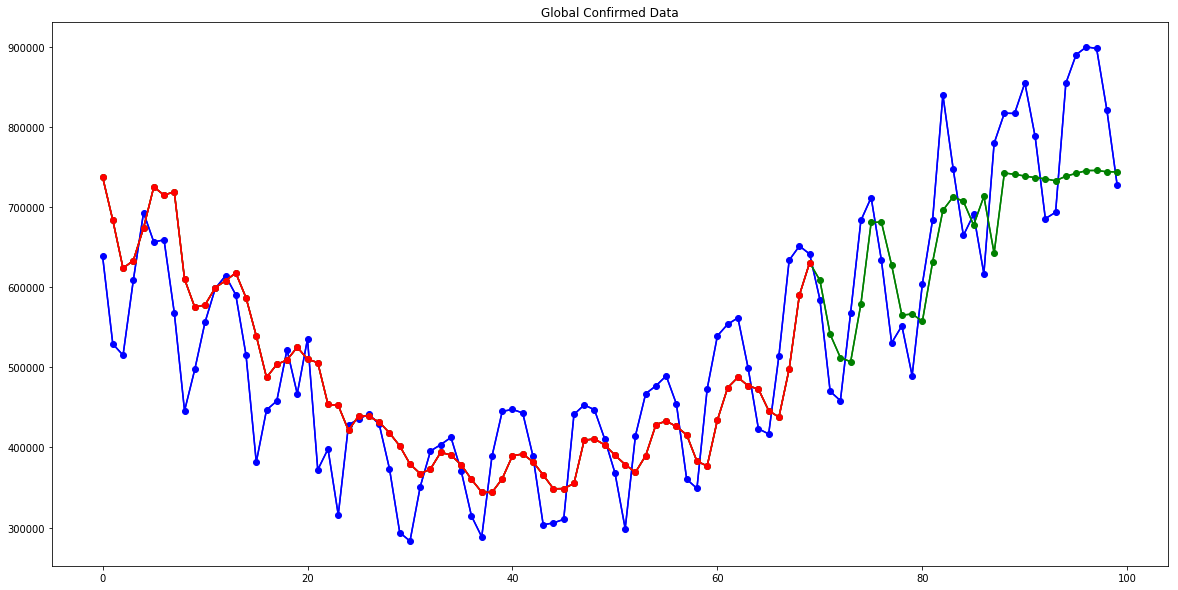

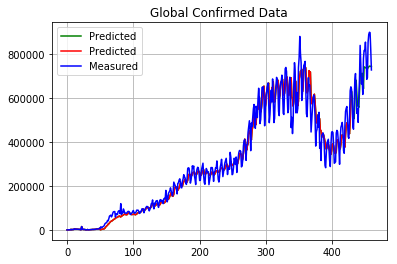

-----------------------------------------------------------------------------------------
| end of epoch  70 | time:  3.29s | mse loss 0.12810 | rmsle loss 0.13594 
-----------------------------------------------------------------------------------------
| epoch  71 |     1/    7 batches | lr 0.000131 | 71.48 ms | loss 0.01280 | ppl     1.01
| epoch  71 |     2/    7 batches | lr 0.000131 | 30.68 ms | loss 0.04675 | ppl     1.05
| epoch  71 |     3/    7 batches | lr 0.000131 | 29.41 ms | loss 0.08563 | ppl     1.09
| epoch  71 |     4/    7 batches | lr 0.000131 | 34.52 ms | loss 0.00369 | ppl     1.00


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch  71 |     5/    7 batches | lr 0.000131 | 36.95 ms | loss 0.01167 | ppl     1.01
| epoch  71 |     6/    7 batches | lr 0.000131 | 34.96 ms | loss 0.06880 | ppl     1.07
| epoch  71 |     7/    7 batches | lr 0.000131 | 28.37 ms | loss 0.10010 | ppl     1.11
| epoch  72 |     1/    7 batches | lr 0.000124 | 70.64 ms | loss 0.01267 | ppl     1.01
| epoch  72 |     2/    7 batches | lr 0.000124 | 33.13 ms | loss 0.04617 | ppl     1.05
| epoch  72 |     3/    7 batches | lr 0.000124 | 30.83 ms | loss 0.08683 | ppl     1.09
| epoch  72 |     4/    7 batches | lr 0.000124 | 29.93 ms | loss 0.00380 | ppl     1.00
| epoch  72 |     5/    7 batches | lr 0.000124 | 34.12 ms | loss 0.01164 | ppl     1.01
| epoch  72 |     6/    7 batches | lr 0.000124 | 34.71 ms | loss 0.06883 | ppl     1.07
| epoch  72 |     7/    7 batches | lr 0.000124 | 23.96 ms | loss 0.10110 | ppl     1.11
| epoch  73 |     1/    7 batches | lr 0.000118 | 48.70 ms | loss 0.01289 | ppl     1.01
| epoch  73 |     2/ 

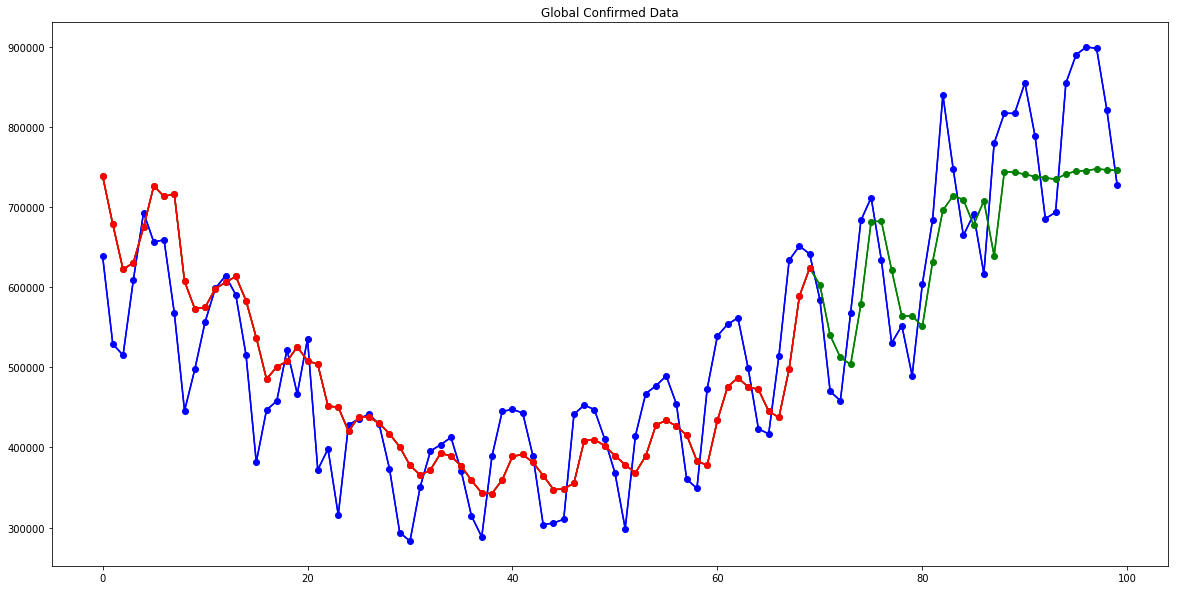

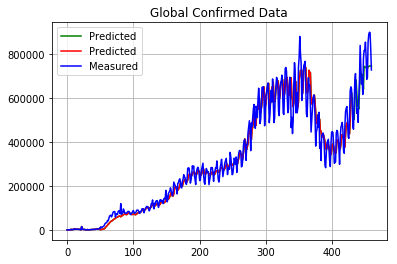

-----------------------------------------------------------------------------------------
| end of epoch  80 | time:  3.07s | mse loss 0.12567 | rmsle loss 0.13478 
-----------------------------------------------------------------------------------------
| epoch  81 |     1/    7 batches | lr 0.000078 | 49.65 ms | loss 0.01280 | ppl     1.01
| epoch  81 |     2/    7 batches | lr 0.000078 | 24.12 ms | loss 0.04640 | ppl     1.05
| epoch  81 |     3/    7 batches | lr 0.000078 | 23.57 ms | loss 0.08404 | ppl     1.09
| epoch  81 |     4/    7 batches | lr 0.000078 | 23.58 ms | loss 0.00367 | ppl     1.00
| epoch  81 |     5/    7 batches | lr 0.000078 | 23.56 ms | loss 0.01146 | ppl     1.01
| epoch  81 |     6/    7 batches | lr 0.000078 | 23.44 ms | loss 0.06825 | ppl     1.07
| epoch  81 |     7/    7 batches | lr 0.000078 | 22.60 ms | loss 0.10021 | ppl     1.11


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch  82 |     1/    7 batches | lr 0.000075 | 47.64 ms | loss 0.01269 | ppl     1.01
| epoch  82 |     2/    7 batches | lr 0.000075 | 25.43 ms | loss 0.04585 | ppl     1.05
| epoch  82 |     3/    7 batches | lr 0.000075 | 25.10 ms | loss 0.08460 | ppl     1.09
| epoch  82 |     4/    7 batches | lr 0.000075 | 25.26 ms | loss 0.00366 | ppl     1.00
| epoch  82 |     5/    7 batches | lr 0.000075 | 25.29 ms | loss 0.01143 | ppl     1.01
| epoch  82 |     6/    7 batches | lr 0.000075 | 25.23 ms | loss 0.06745 | ppl     1.07
| epoch  82 |     7/    7 batches | lr 0.000075 | 24.90 ms | loss 0.09801 | ppl     1.10
| epoch  83 |     1/    7 batches | lr 0.000071 | 52.17 ms | loss 0.01263 | ppl     1.01
| epoch  83 |     2/    7 batches | lr 0.000071 | 25.01 ms | loss 0.04621 | ppl     1.05
| epoch  83 |     3/    7 batches | lr 0.000071 | 25.10 ms | loss 0.08530 | ppl     1.09
| epoch  83 |     4/    7 batches | lr 0.000071 | 24.90 ms | loss 0.00365 | ppl     1.00
| epoch  83 |     5/ 

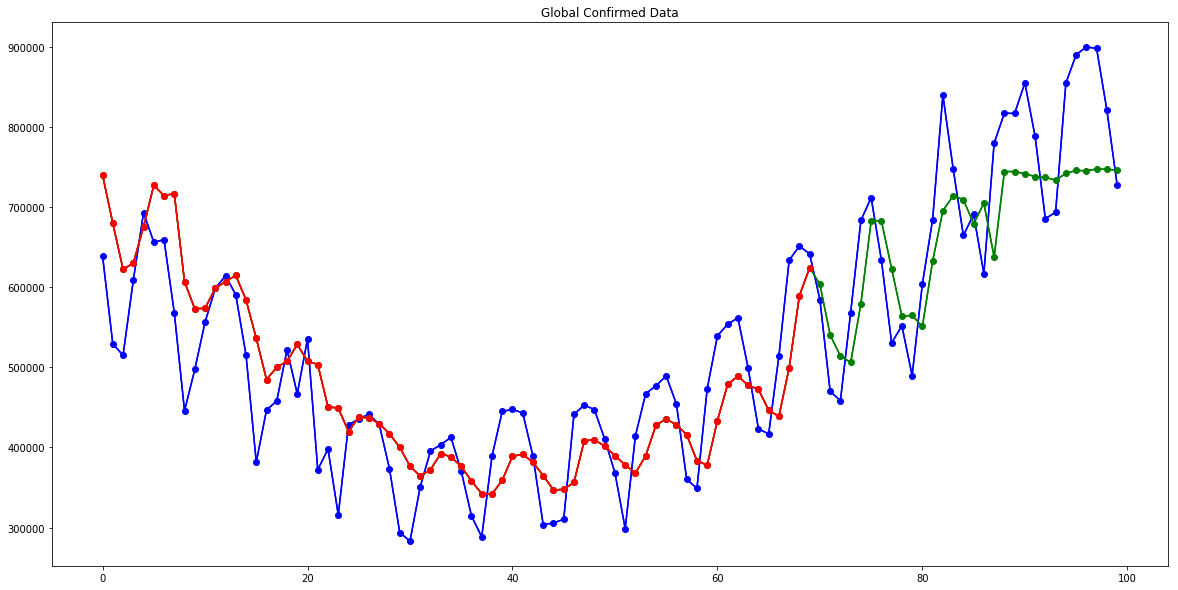

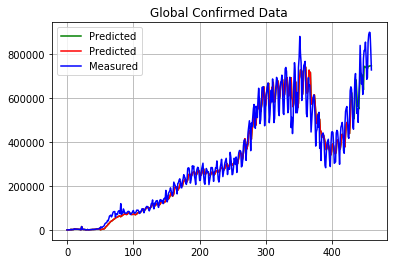

-----------------------------------------------------------------------------------------
| end of epoch  90 | time:  3.64s | mse loss 0.12529 | rmsle loss 0.13465 
-----------------------------------------------------------------------------------------
| epoch  91 |     1/    7 batches | lr 0.000047 | 47.97 ms | loss 0.01241 | ppl     1.01
| epoch  91 |     2/    7 batches | lr 0.000047 | 25.10 ms | loss 0.04564 | ppl     1.05
| epoch  91 |     3/    7 batches | lr 0.000047 | 25.42 ms | loss 0.08463 | ppl     1.09
| epoch  91 |     4/    7 batches | lr 0.000047 | 25.23 ms | loss 0.00375 | ppl     1.00
| epoch  91 |     5/    7 batches | lr 0.000047 | 24.94 ms | loss 0.01129 | ppl     1.01
| epoch  91 |     6/    7 batches | lr 0.000047 | 25.10 ms | loss 0.06840 | ppl     1.07
| epoch  91 |     7/    7 batches | lr 0.000047 | 24.30 ms | loss 0.09832 | ppl     1.10


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch  92 |     1/    7 batches | lr 0.000045 | 52.16 ms | loss 0.01255 | ppl     1.01
| epoch  92 |     2/    7 batches | lr 0.000045 | 25.38 ms | loss 0.04618 | ppl     1.05
| epoch  92 |     3/    7 batches | lr 0.000045 | 32.09 ms | loss 0.08471 | ppl     1.09
| epoch  92 |     4/    7 batches | lr 0.000045 | 25.27 ms | loss 0.00379 | ppl     1.00
| epoch  92 |     5/    7 batches | lr 0.000045 | 25.25 ms | loss 0.01142 | ppl     1.01
| epoch  92 |     6/    7 batches | lr 0.000045 | 25.15 ms | loss 0.06641 | ppl     1.07
| epoch  92 |     7/    7 batches | lr 0.000045 | 24.12 ms | loss 0.09709 | ppl     1.10
| epoch  93 |     1/    7 batches | lr 0.000042 | 50.75 ms | loss 0.01248 | ppl     1.01
| epoch  93 |     2/    7 batches | lr 0.000042 | 25.06 ms | loss 0.04616 | ppl     1.05
| epoch  93 |     3/    7 batches | lr 0.000042 | 25.16 ms | loss 0.08431 | ppl     1.09
| epoch  93 |     4/    7 batches | lr 0.000042 | 25.21 ms | loss 0.00373 | ppl     1.00
| epoch  93 |     5/ 

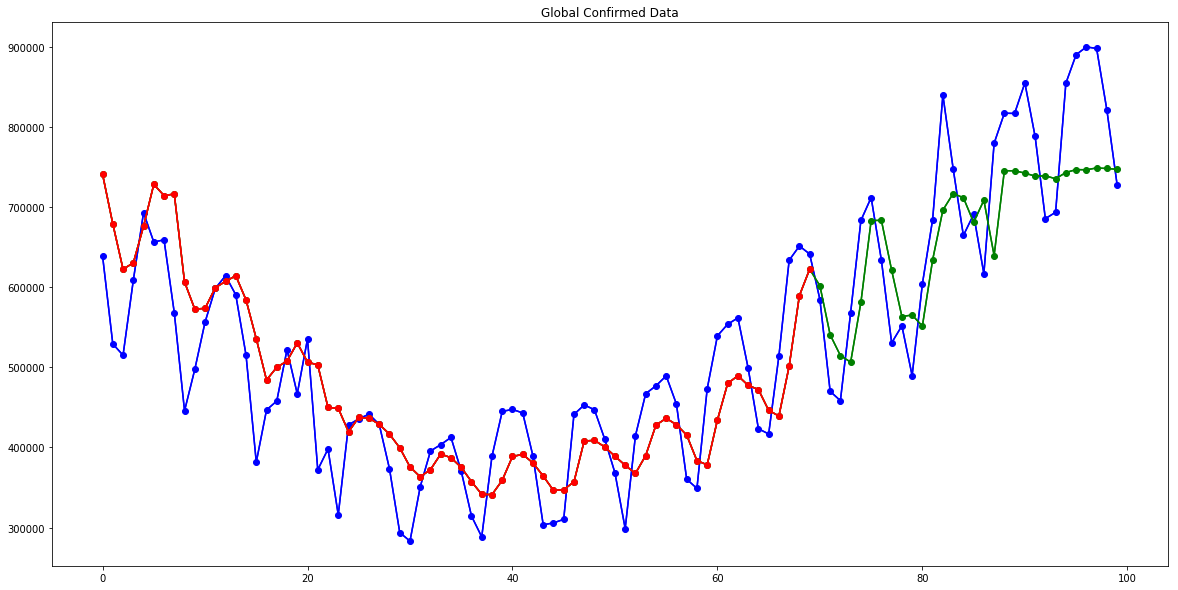

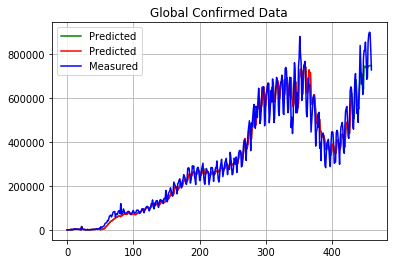

-----------------------------------------------------------------------------------------
| end of epoch 100 | time:  3.41s | mse loss 0.12386 | rmsle loss 0.13390 
-----------------------------------------------------------------------------------------
| epoch 101 |     1/    7 batches | lr 0.000028 | 49.98 ms | loss 0.01257 | ppl     1.01
| epoch 101 |     2/    7 batches | lr 0.000028 | 25.78 ms | loss 0.04521 | ppl     1.05
| epoch 101 |     3/    7 batches | lr 0.000028 | 25.39 ms | loss 0.08431 | ppl     1.09
| epoch 101 |     4/    7 batches | lr 0.000028 | 25.60 ms | loss 0.00355 | ppl     1.00
| epoch 101 |     5/    7 batches | lr 0.000028 | 25.33 ms | loss 0.01135 | ppl     1.01
| epoch 101 |     6/    7 batches | lr 0.000028 | 25.48 ms | loss 0.06858 | ppl     1.07


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 101 |     7/    7 batches | lr 0.000028 | 24.15 ms | loss 0.09804 | ppl     1.10
| epoch 102 |     1/    7 batches | lr 0.000027 | 51.36 ms | loss 0.01263 | ppl     1.01
| epoch 102 |     2/    7 batches | lr 0.000027 | 25.82 ms | loss 0.04587 | ppl     1.05
| epoch 102 |     3/    7 batches | lr 0.000027 | 24.21 ms | loss 0.08469 | ppl     1.09
| epoch 102 |     4/    7 batches | lr 0.000027 | 24.36 ms | loss 0.00366 | ppl     1.00
| epoch 102 |     5/    7 batches | lr 0.000027 | 24.18 ms | loss 0.01148 | ppl     1.01
| epoch 102 |     6/    7 batches | lr 0.000027 | 25.56 ms | loss 0.06754 | ppl     1.07
| epoch 102 |     7/    7 batches | lr 0.000027 | 23.69 ms | loss 0.09637 | ppl     1.10
| epoch 103 |     1/    7 batches | lr 0.000025 | 52.78 ms | loss 0.01239 | ppl     1.01
| epoch 103 |     2/    7 batches | lr 0.000025 | 25.09 ms | loss 0.04588 | ppl     1.05
| epoch 103 |     3/    7 batches | lr 0.000025 | 25.24 ms | loss 0.08569 | ppl     1.09
| epoch 103 |     4/ 

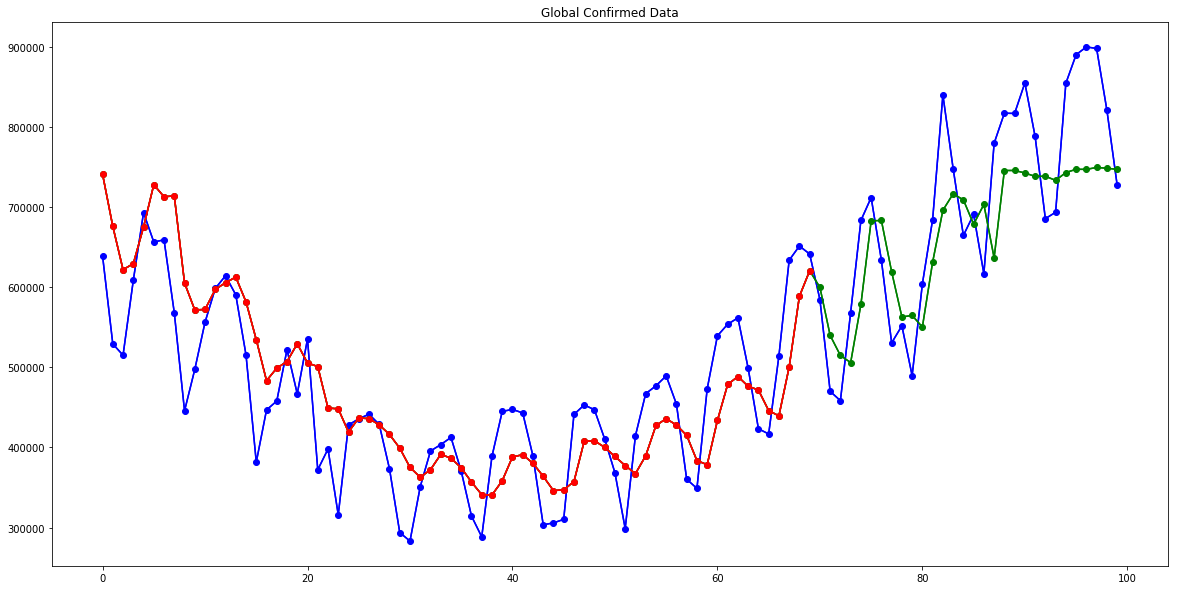

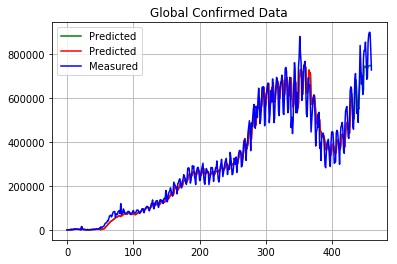

-----------------------------------------------------------------------------------------
| end of epoch 110 | time:  3.52s | mse loss 0.12349 | rmsle loss 0.13378 
-----------------------------------------------------------------------------------------
| epoch 111 |     1/    7 batches | lr 0.000017 | 50.45 ms | loss 0.01230 | ppl     1.01
| epoch 111 |     2/    7 batches | lr 0.000017 | 34.88 ms | loss 0.04555 | ppl     1.05
| epoch 111 |     3/    7 batches | lr 0.000017 | 29.55 ms | loss 0.08409 | ppl     1.09
| epoch 111 |     4/    7 batches | lr 0.000017 | 29.49 ms | loss 0.00359 | ppl     1.00
| epoch 111 |     5/    7 batches | lr 0.000017 | 27.21 ms | loss 0.01123 | ppl     1.01
| epoch 111 |     6/    7 batches | lr 0.000017 | 27.15 ms | loss 0.06674 | ppl     1.07


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 111 |     7/    7 batches | lr 0.000017 | 27.09 ms | loss 0.09842 | ppl     1.10
| epoch 112 |     1/    7 batches | lr 0.000016 | 55.03 ms | loss 0.01237 | ppl     1.01
| epoch 112 |     2/    7 batches | lr 0.000016 | 25.16 ms | loss 0.04562 | ppl     1.05
| epoch 112 |     3/    7 batches | lr 0.000016 | 25.31 ms | loss 0.08361 | ppl     1.09
| epoch 112 |     4/    7 batches | lr 0.000016 | 25.74 ms | loss 0.00365 | ppl     1.00
| epoch 112 |     5/    7 batches | lr 0.000016 | 25.45 ms | loss 0.01132 | ppl     1.01
| epoch 112 |     6/    7 batches | lr 0.000016 | 25.37 ms | loss 0.06899 | ppl     1.07
| epoch 112 |     7/    7 batches | lr 0.000016 | 24.38 ms | loss 0.09735 | ppl     1.10
| epoch 113 |     1/    7 batches | lr 0.000015 | 50.72 ms | loss 0.01221 | ppl     1.01
| epoch 113 |     2/    7 batches | lr 0.000015 | 29.29 ms | loss 0.04583 | ppl     1.05
| epoch 113 |     3/    7 batches | lr 0.000015 | 25.19 ms | loss 0.08277 | ppl     1.09
| epoch 113 |     4/ 

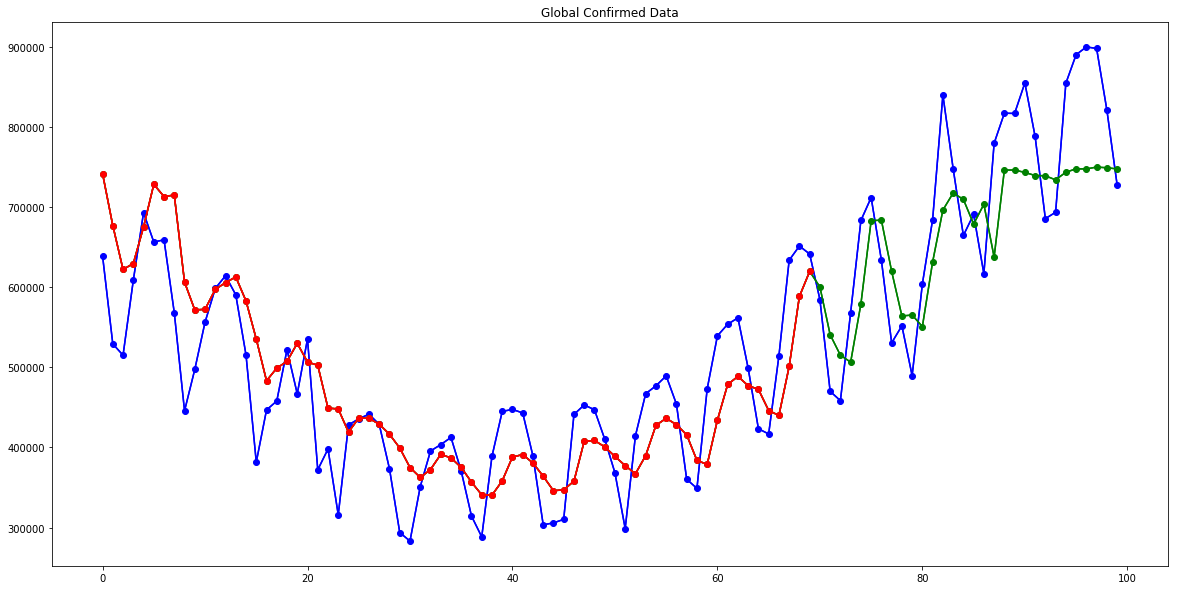

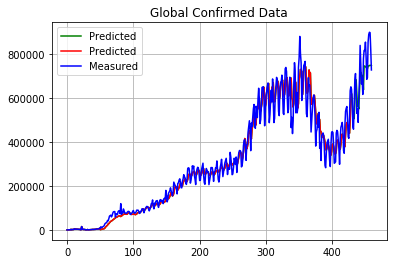

-----------------------------------------------------------------------------------------
| end of epoch 120 | time:  3.37s | mse loss 0.12283 | rmsle loss 0.13351 
-----------------------------------------------------------------------------------------
| epoch 121 |     1/    7 batches | lr 0.000010 | 50.30 ms | loss 0.01251 | ppl     1.01
| epoch 121 |     2/    7 batches | lr 0.000010 | 23.98 ms | loss 0.04555 | ppl     1.05
| epoch 121 |     3/    7 batches | lr 0.000010 | 23.79 ms | loss 0.08380 | ppl     1.09
| epoch 121 |     4/    7 batches | lr 0.000010 | 23.79 ms | loss 0.00358 | ppl     1.00
| epoch 121 |     5/    7 batches | lr 0.000010 | 23.51 ms | loss 0.01125 | ppl     1.01
| epoch 121 |     6/    7 batches | lr 0.000010 | 23.82 ms | loss 0.06793 | ppl     1.07
| epoch 121 |     7/    7 batches | lr 0.000010 | 22.06 ms | loss 0.09802 | ppl     1.10


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 122 |     1/    7 batches | lr 0.000010 | 48.11 ms | loss 0.01239 | ppl     1.01
| epoch 122 |     2/    7 batches | lr 0.000010 | 24.56 ms | loss 0.04531 | ppl     1.05
| epoch 122 |     3/    7 batches | lr 0.000010 | 23.86 ms | loss 0.08498 | ppl     1.09
| epoch 122 |     4/    7 batches | lr 0.000010 | 23.56 ms | loss 0.00352 | ppl     1.00
| epoch 122 |     5/    7 batches | lr 0.000010 | 23.56 ms | loss 0.01126 | ppl     1.01
| epoch 122 |     6/    7 batches | lr 0.000010 | 23.73 ms | loss 0.06866 | ppl     1.07
| epoch 122 |     7/    7 batches | lr 0.000010 | 22.10 ms | loss 0.09799 | ppl     1.10
| epoch 123 |     1/    7 batches | lr 0.000009 | 47.64 ms | loss 0.01257 | ppl     1.01
| epoch 123 |     2/    7 batches | lr 0.000009 | 25.02 ms | loss 0.04467 | ppl     1.05
| epoch 123 |     3/    7 batches | lr 0.000009 | 23.94 ms | loss 0.08376 | ppl     1.09
| epoch 123 |     4/    7 batches | lr 0.000009 | 23.63 ms | loss 0.00367 | ppl     1.00
| epoch 123 |     5/ 

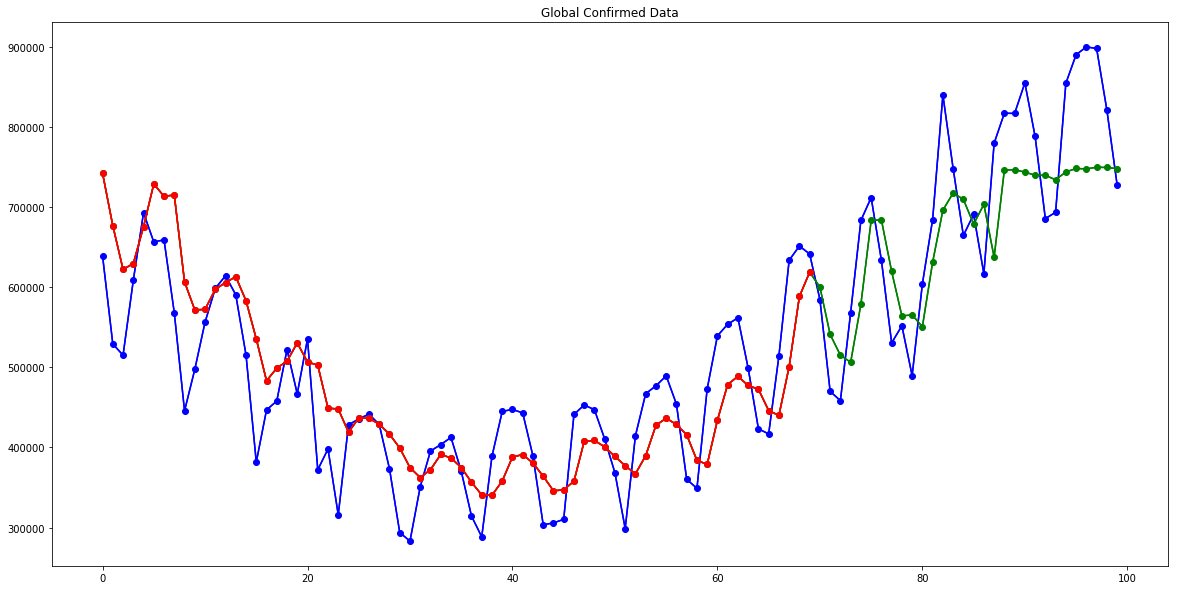

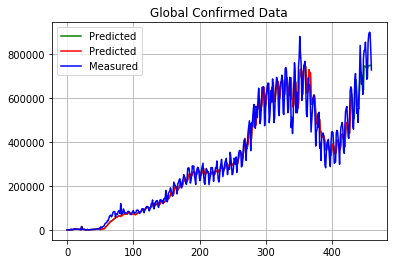

-----------------------------------------------------------------------------------------
| end of epoch 130 | time:  3.19s | mse loss 0.12281 | rmsle loss 0.13357 
-----------------------------------------------------------------------------------------
| epoch 131 |     1/    7 batches | lr 0.000006 | 62.51 ms | loss 0.01245 | ppl     1.01
| epoch 131 |     2/    7 batches | lr 0.000006 | 29.67 ms | loss 0.04555 | ppl     1.05
| epoch 131 |     3/    7 batches | lr 0.000006 | 29.27 ms | loss 0.08448 | ppl     1.09
| epoch 131 |     4/    7 batches | lr 0.000006 | 31.13 ms | loss 0.00359 | ppl     1.00
| epoch 131 |     5/    7 batches | lr 0.000006 | 36.58 ms | loss 0.01142 | ppl     1.01


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 131 |     6/    7 batches | lr 0.000006 | 34.52 ms | loss 0.06734 | ppl     1.07
| epoch 131 |     7/    7 batches | lr 0.000006 | 30.11 ms | loss 0.09851 | ppl     1.10
| epoch 132 |     1/    7 batches | lr 0.000006 | 64.29 ms | loss 0.01234 | ppl     1.01
| epoch 132 |     2/    7 batches | lr 0.000006 | 36.22 ms | loss 0.04473 | ppl     1.05
| epoch 132 |     3/    7 batches | lr 0.000006 | 33.37 ms | loss 0.08332 | ppl     1.09
| epoch 132 |     4/    7 batches | lr 0.000006 | 30.42 ms | loss 0.00356 | ppl     1.00
| epoch 132 |     5/    7 batches | lr 0.000006 | 30.93 ms | loss 0.01121 | ppl     1.01
| epoch 132 |     6/    7 batches | lr 0.000006 | 34.46 ms | loss 0.06757 | ppl     1.07
| epoch 132 |     7/    7 batches | lr 0.000006 | 28.36 ms | loss 0.09708 | ppl     1.10
| epoch 133 |     1/    7 batches | lr 0.000005 | 64.02 ms | loss 0.01216 | ppl     1.01
| epoch 133 |     2/    7 batches | lr 0.000005 | 29.71 ms | loss 0.04498 | ppl     1.05
| epoch 133 |     3/ 

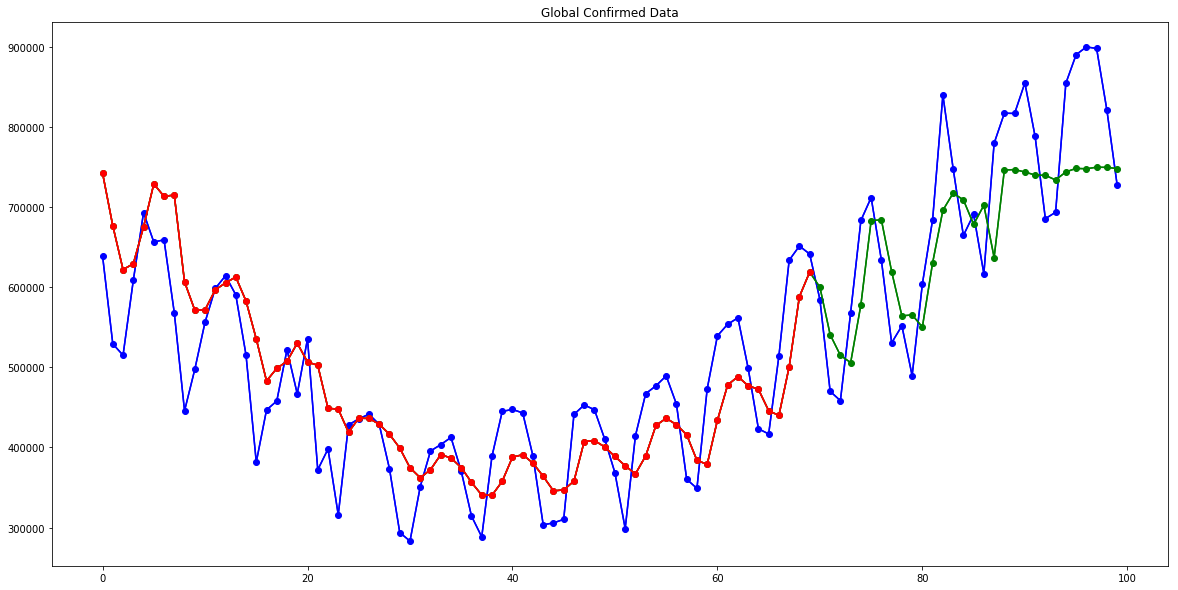

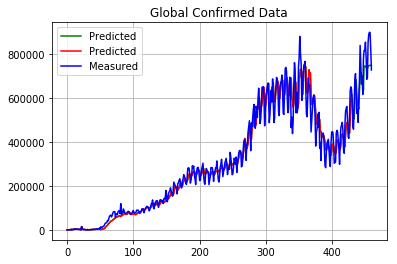

-----------------------------------------------------------------------------------------
| end of epoch 140 | time:  3.09s | mse loss 0.12276 | rmsle loss 0.13358 
-----------------------------------------------------------------------------------------
| epoch 141 |     1/    7 batches | lr 0.000004 | 49.64 ms | loss 0.01240 | ppl     1.01
| epoch 141 |     2/    7 batches | lr 0.000004 | 23.61 ms | loss 0.04560 | ppl     1.05
| epoch 141 |     3/    7 batches | lr 0.000004 | 23.28 ms | loss 0.08501 | ppl     1.09
| epoch 141 |     4/    7 batches | lr 0.000004 | 23.48 ms | loss 0.00355 | ppl     1.00
| epoch 141 |     5/    7 batches | lr 0.000004 | 23.37 ms | loss 0.01128 | ppl     1.01
| epoch 141 |     6/    7 batches | lr 0.000004 | 23.44 ms | loss 0.06759 | ppl     1.07
| epoch 141 |     7/    7 batches | lr 0.000004 | 22.42 ms | loss 0.09723 | ppl     1.10


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 142 |     1/    7 batches | lr 0.000003 | 48.02 ms | loss 0.01243 | ppl     1.01
| epoch 142 |     2/    7 batches | lr 0.000003 | 24.04 ms | loss 0.04519 | ppl     1.05
| epoch 142 |     3/    7 batches | lr 0.000003 | 23.45 ms | loss 0.08429 | ppl     1.09
| epoch 142 |     4/    7 batches | lr 0.000003 | 27.61 ms | loss 0.00356 | ppl     1.00
| epoch 142 |     5/    7 batches | lr 0.000003 | 23.50 ms | loss 0.01127 | ppl     1.01
| epoch 142 |     6/    7 batches | lr 0.000003 | 23.35 ms | loss 0.06697 | ppl     1.07
| epoch 142 |     7/    7 batches | lr 0.000003 | 22.36 ms | loss 0.09804 | ppl     1.10
| epoch 143 |     1/    7 batches | lr 0.000003 | 52.41 ms | loss 0.01247 | ppl     1.01
| epoch 143 |     2/    7 batches | lr 0.000003 | 25.71 ms | loss 0.04522 | ppl     1.05
| epoch 143 |     3/    7 batches | lr 0.000003 | 24.97 ms | loss 0.08575 | ppl     1.09
| epoch 143 |     4/    7 batches | lr 0.000003 | 25.39 ms | loss 0.00357 | ppl     1.00
| epoch 143 |     5/ 

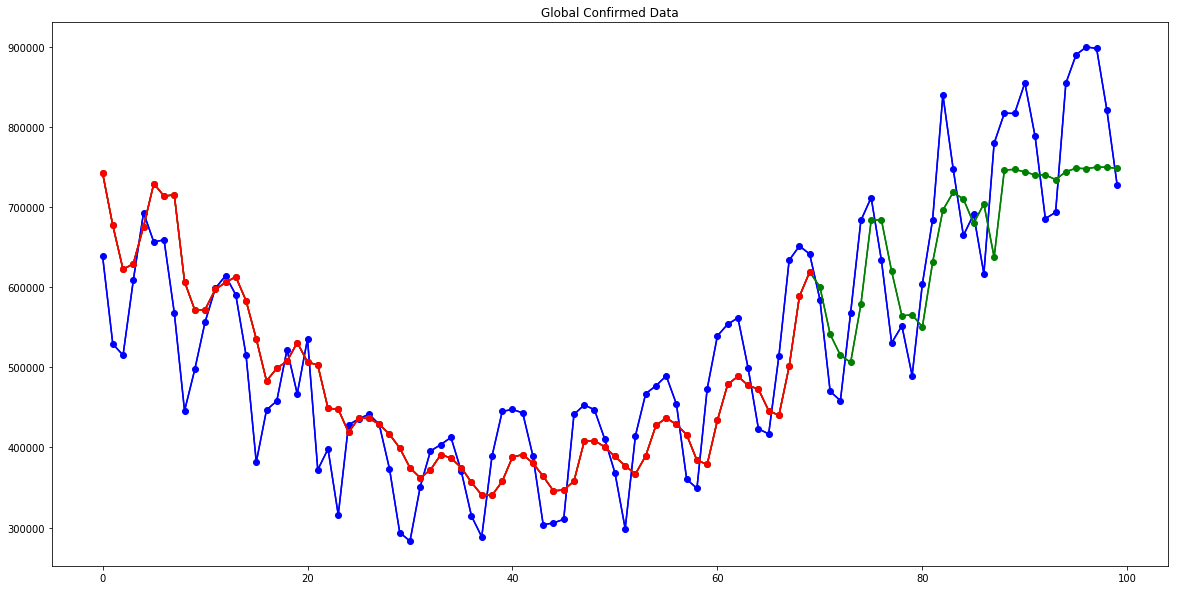

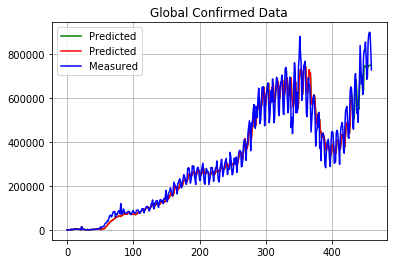

-----------------------------------------------------------------------------------------
| end of epoch 150 | time:  3.28s | mse loss 0.12269 | rmsle loss 0.13357 
-----------------------------------------------------------------------------------------
| epoch 151 |     1/    7 batches | lr 0.000002 | 54.11 ms | loss 0.01248 | ppl     1.01
| epoch 151 |     2/    7 batches | lr 0.000002 | 29.33 ms | loss 0.04594 | ppl     1.05
| epoch 151 |     3/    7 batches | lr 0.000002 | 25.26 ms | loss 0.08362 | ppl     1.09
| epoch 151 |     4/    7 batches | lr 0.000002 | 23.97 ms | loss 0.00365 | ppl     1.00
| epoch 151 |     5/    7 batches | lr 0.000002 | 26.65 ms | loss 0.01123 | ppl     1.01
| epoch 151 |     6/    7 batches | lr 0.000002 | 29.87 ms | loss 0.06684 | ppl     1.07


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 151 |     7/    7 batches | lr 0.000002 | 23.68 ms | loss 0.09563 | ppl     1.10
| epoch 152 |     1/    7 batches | lr 0.000002 | 49.23 ms | loss 0.01230 | ppl     1.01
| epoch 152 |     2/    7 batches | lr 0.000002 | 27.38 ms | loss 0.04579 | ppl     1.05
| epoch 152 |     3/    7 batches | lr 0.000002 | 29.81 ms | loss 0.08496 | ppl     1.09
| epoch 152 |     4/    7 batches | lr 0.000002 | 27.72 ms | loss 0.00353 | ppl     1.00
| epoch 152 |     5/    7 batches | lr 0.000002 | 25.21 ms | loss 0.01129 | ppl     1.01
| epoch 152 |     6/    7 batches | lr 0.000002 | 24.00 ms | loss 0.06716 | ppl     1.07
| epoch 152 |     7/    7 batches | lr 0.000002 | 25.41 ms | loss 0.09758 | ppl     1.10
| epoch 153 |     1/    7 batches | lr 0.000002 | 57.14 ms | loss 0.01215 | ppl     1.01
| epoch 153 |     2/    7 batches | lr 0.000002 | 25.31 ms | loss 0.04612 | ppl     1.05
| epoch 153 |     3/    7 batches | lr 0.000002 | 23.88 ms | loss 0.08472 | ppl     1.09
| epoch 153 |     4/ 

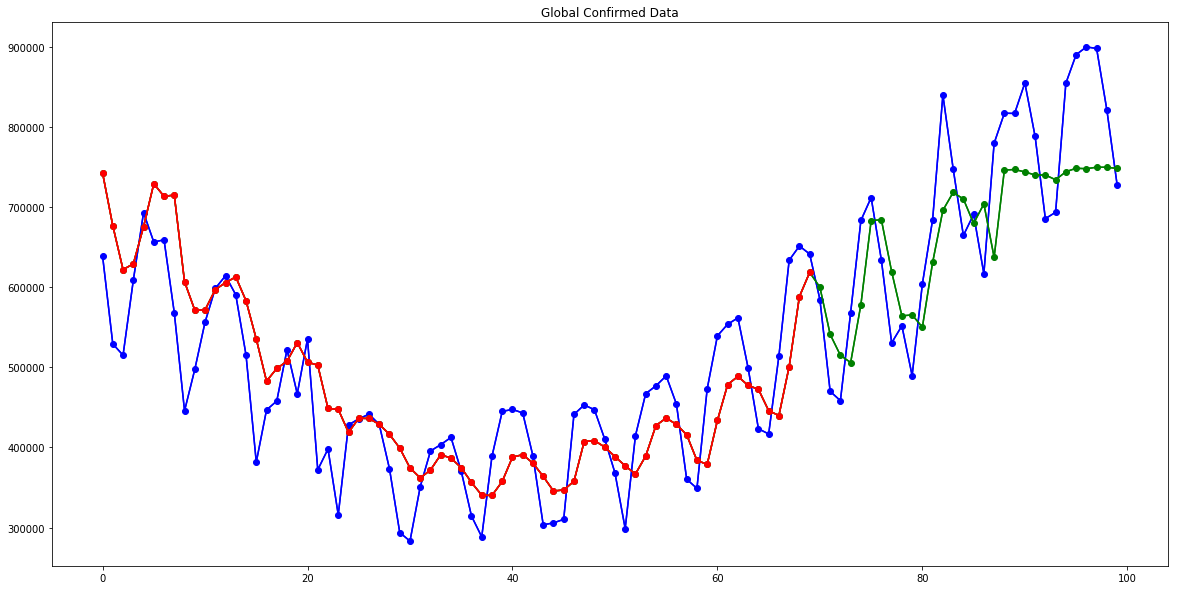

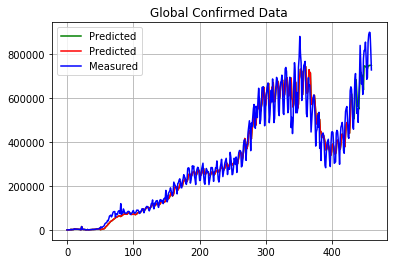

-----------------------------------------------------------------------------------------
| end of epoch 160 | time:  3.04s | mse loss 0.12285 | rmsle loss 0.13365 
-----------------------------------------------------------------------------------------
| epoch 161 |     1/    7 batches | lr 0.000001 | 58.09 ms | loss 0.01221 | ppl     1.01
| epoch 161 |     2/    7 batches | lr 0.000001 | 28.85 ms | loss 0.04543 | ppl     1.05
| epoch 161 |     3/    7 batches | lr 0.000001 | 31.15 ms | loss 0.08500 | ppl     1.09
| epoch 161 |     4/    7 batches | lr 0.000001 | 24.12 ms | loss 0.00355 | ppl     1.00
| epoch 161 |     5/    7 batches | lr 0.000001 | 25.18 ms | loss 0.01123 | ppl     1.01
| epoch 161 |     6/    7 batches | lr 0.000001 | 25.08 ms | loss 0.06714 | ppl     1.07


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 161 |     7/    7 batches | lr 0.000001 | 24.64 ms | loss 0.09774 | ppl     1.10
| epoch 162 |     1/    7 batches | lr 0.000001 | 50.39 ms | loss 0.01241 | ppl     1.01
| epoch 162 |     2/    7 batches | lr 0.000001 | 25.44 ms | loss 0.04574 | ppl     1.05
| epoch 162 |     3/    7 batches | lr 0.000001 | 25.22 ms | loss 0.08431 | ppl     1.09
| epoch 162 |     4/    7 batches | lr 0.000001 | 25.64 ms | loss 0.00364 | ppl     1.00
| epoch 162 |     5/    7 batches | lr 0.000001 | 25.24 ms | loss 0.01128 | ppl     1.01
| epoch 162 |     6/    7 batches | lr 0.000001 | 25.20 ms | loss 0.06665 | ppl     1.07
| epoch 162 |     7/    7 batches | lr 0.000001 | 24.99 ms | loss 0.09883 | ppl     1.10
| epoch 163 |     1/    7 batches | lr 0.000001 | 50.31 ms | loss 0.01236 | ppl     1.01
| epoch 163 |     2/    7 batches | lr 0.000001 | 25.12 ms | loss 0.04530 | ppl     1.05
| epoch 163 |     3/    7 batches | lr 0.000001 | 25.05 ms | loss 0.08386 | ppl     1.09
| epoch 163 |     4/ 

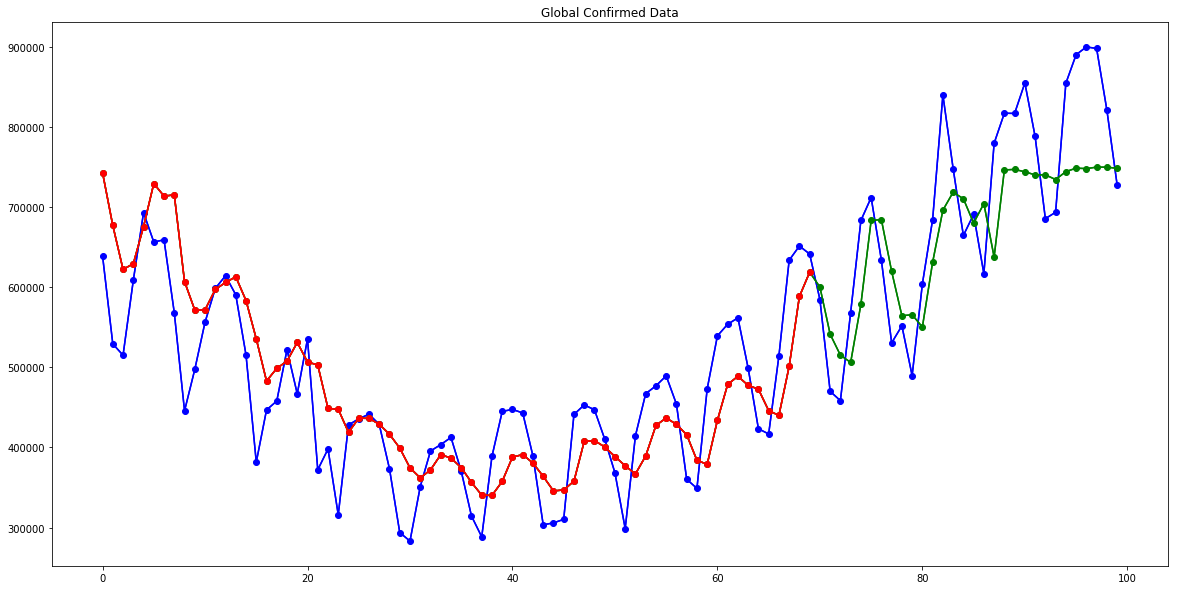

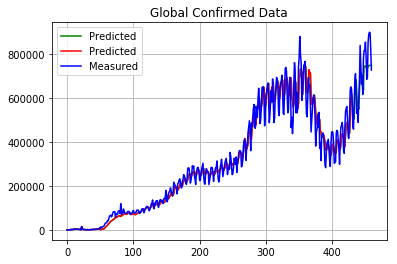

-----------------------------------------------------------------------------------------
| end of epoch 170 | time:  3.44s | mse loss 0.12270 | rmsle loss 0.13359 
-----------------------------------------------------------------------------------------
| epoch 171 |     1/    7 batches | lr 0.000001 | 59.18 ms | loss 0.01243 | ppl     1.01
| epoch 171 |     2/    7 batches | lr 0.000001 | 28.93 ms | loss 0.04460 | ppl     1.05
| epoch 171 |     3/    7 batches | lr 0.000001 | 29.03 ms | loss 0.08434 | ppl     1.09
| epoch 171 |     4/    7 batches | lr 0.000001 | 29.26 ms | loss 0.00362 | ppl     1.00
| epoch 171 |     5/    7 batches | lr 0.000001 | 28.95 ms | loss 0.01130 | ppl     1.01


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 171 |     6/    7 batches | lr 0.000001 | 29.94 ms | loss 0.06780 | ppl     1.07
| epoch 171 |     7/    7 batches | lr 0.000001 | 27.64 ms | loss 0.09643 | ppl     1.10
| epoch 172 |     1/    7 batches | lr 0.000001 | 59.19 ms | loss 0.01227 | ppl     1.01
| epoch 172 |     2/    7 batches | lr 0.000001 | 29.13 ms | loss 0.04549 | ppl     1.05
| epoch 172 |     3/    7 batches | lr 0.000001 | 29.21 ms | loss 0.08444 | ppl     1.09
| epoch 172 |     4/    7 batches | lr 0.000001 | 32.80 ms | loss 0.00360 | ppl     1.00
| epoch 172 |     5/    7 batches | lr 0.000001 | 29.91 ms | loss 0.01126 | ppl     1.01
| epoch 172 |     6/    7 batches | lr 0.000001 | 29.02 ms | loss 0.06838 | ppl     1.07
| epoch 172 |     7/    7 batches | lr 0.000001 | 27.63 ms | loss 0.09797 | ppl     1.10
| epoch 173 |     1/    7 batches | lr 0.000001 | 58.44 ms | loss 0.01243 | ppl     1.01
| epoch 173 |     2/    7 batches | lr 0.000001 | 28.86 ms | loss 0.04522 | ppl     1.05
| epoch 173 |     3/ 

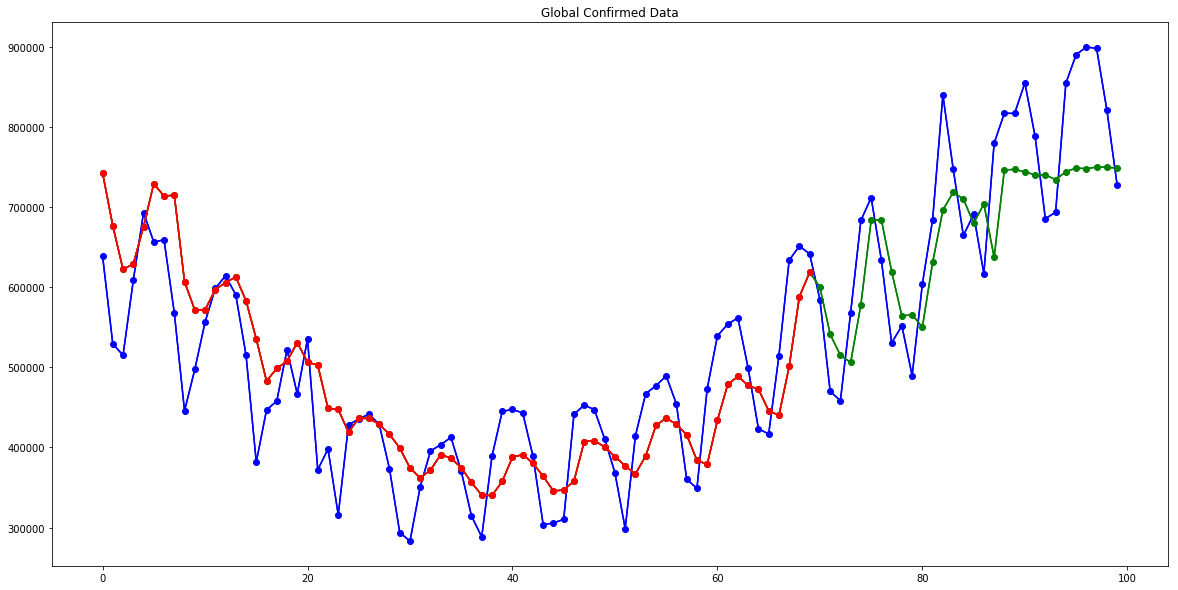

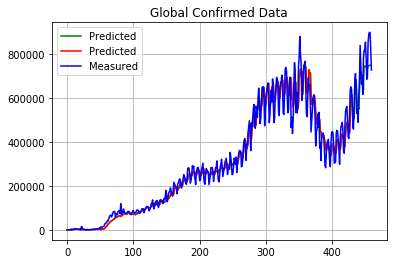

-----------------------------------------------------------------------------------------
| end of epoch 180 | time:  3.73s | mse loss 0.12270 | rmsle loss 0.13359 
-----------------------------------------------------------------------------------------
| epoch 181 |     1/    7 batches | lr 0.000000 | 55.59 ms | loss 0.01236 | ppl     1.01
| epoch 181 |     2/    7 batches | lr 0.000000 | 26.02 ms | loss 0.04501 | ppl     1.05
| epoch 181 |     3/    7 batches | lr 0.000000 | 25.54 ms | loss 0.08484 | ppl     1.09
| epoch 181 |     4/    7 batches | lr 0.000000 | 25.65 ms | loss 0.00372 | ppl     1.00
| epoch 181 |     5/    7 batches | lr 0.000000 | 25.96 ms | loss 0.01120 | ppl     1.01
| epoch 181 |     6/    7 batches | lr 0.000000 | 25.44 ms | loss 0.06918 | ppl     1.07


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 181 |     7/    7 batches | lr 0.000000 | 23.80 ms | loss 0.09828 | ppl     1.10
| epoch 182 |     1/    7 batches | lr 0.000000 | 51.05 ms | loss 0.01240 | ppl     1.01
| epoch 182 |     2/    7 batches | lr 0.000000 | 25.33 ms | loss 0.04537 | ppl     1.05
| epoch 182 |     3/    7 batches | lr 0.000000 | 25.69 ms | loss 0.08416 | ppl     1.09
| epoch 182 |     4/    7 batches | lr 0.000000 | 25.89 ms | loss 0.00367 | ppl     1.00
| epoch 182 |     5/    7 batches | lr 0.000000 | 27.65 ms | loss 0.01131 | ppl     1.01
| epoch 182 |     6/    7 batches | lr 0.000000 | 30.15 ms | loss 0.06841 | ppl     1.07
| epoch 182 |     7/    7 batches | lr 0.000000 | 31.27 ms | loss 0.09713 | ppl     1.10
| epoch 183 |     1/    7 batches | lr 0.000000 | 59.23 ms | loss 0.01239 | ppl     1.01
| epoch 183 |     2/    7 batches | lr 0.000000 | 29.28 ms | loss 0.04474 | ppl     1.05
| epoch 183 |     3/    7 batches | lr 0.000000 | 29.43 ms | loss 0.08467 | ppl     1.09
| epoch 183 |     4/ 

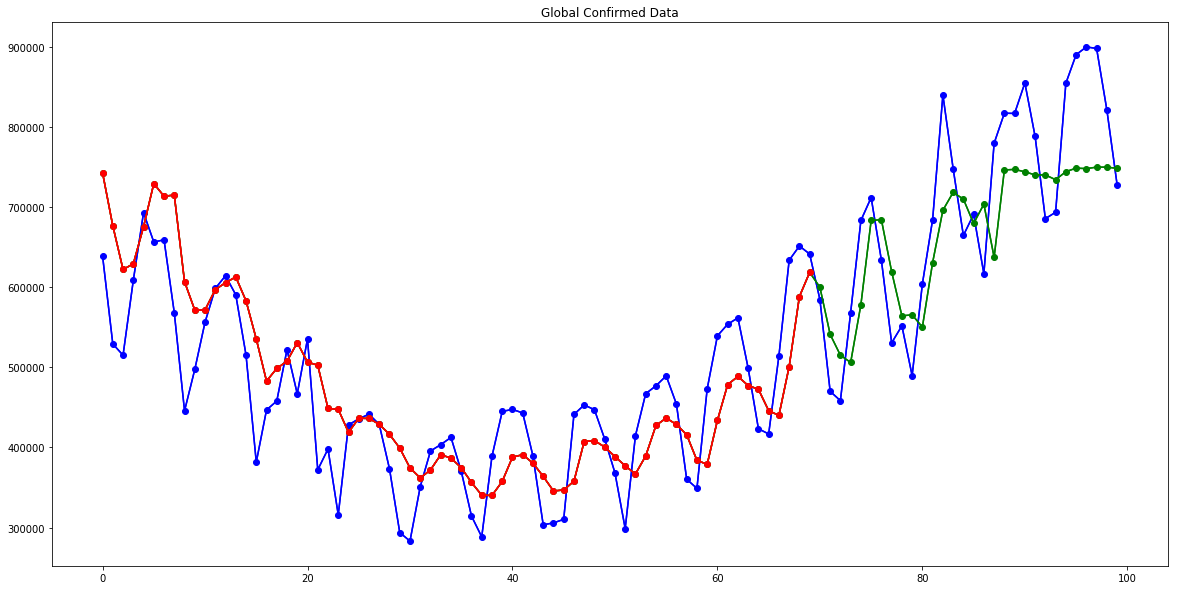

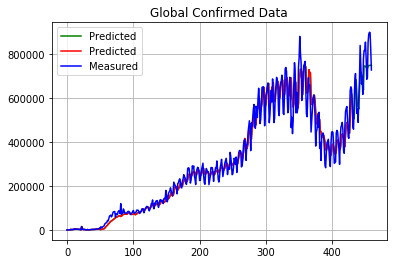

-----------------------------------------------------------------------------------------
| end of epoch 190 | time:  3.09s | mse loss 0.12270 | rmsle loss 0.13358 
-----------------------------------------------------------------------------------------
| epoch 191 |     1/    7 batches | lr 0.000000 | 60.47 ms | loss 0.01231 | ppl     1.01
| epoch 191 |     2/    7 batches | lr 0.000000 | 31.46 ms | loss 0.04543 | ppl     1.05
| epoch 191 |     3/    7 batches | lr 0.000000 | 32.82 ms | loss 0.08429 | ppl     1.09
| epoch 191 |     4/    7 batches | lr 0.000000 | 32.35 ms | loss 0.00353 | ppl     1.00
| epoch 191 |     5/    7 batches | lr 0.000000 | 32.23 ms | loss 0.01124 | ppl     1.01


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 191 |     6/    7 batches | lr 0.000000 | 32.27 ms | loss 0.06701 | ppl     1.07
| epoch 191 |     7/    7 batches | lr 0.000000 | 28.28 ms | loss 0.09644 | ppl     1.10
| epoch 192 |     1/    7 batches | lr 0.000000 | 64.58 ms | loss 0.01249 | ppl     1.01
| epoch 192 |     2/    7 batches | lr 0.000000 | 32.12 ms | loss 0.04590 | ppl     1.05
| epoch 192 |     3/    7 batches | lr 0.000000 | 32.48 ms | loss 0.08440 | ppl     1.09
| epoch 192 |     4/    7 batches | lr 0.000000 | 28.54 ms | loss 0.00351 | ppl     1.00
| epoch 192 |     5/    7 batches | lr 0.000000 | 32.64 ms | loss 0.01122 | ppl     1.01
| epoch 192 |     6/    7 batches | lr 0.000000 | 32.06 ms | loss 0.06732 | ppl     1.07
| epoch 192 |     7/    7 batches | lr 0.000000 | 29.19 ms | loss 0.09798 | ppl     1.10
| epoch 193 |     1/    7 batches | lr 0.000000 | 64.31 ms | loss 0.01231 | ppl     1.01
| epoch 193 |     2/    7 batches | lr 0.000000 | 32.27 ms | loss 0.04520 | ppl     1.05
| epoch 193 |     3/ 

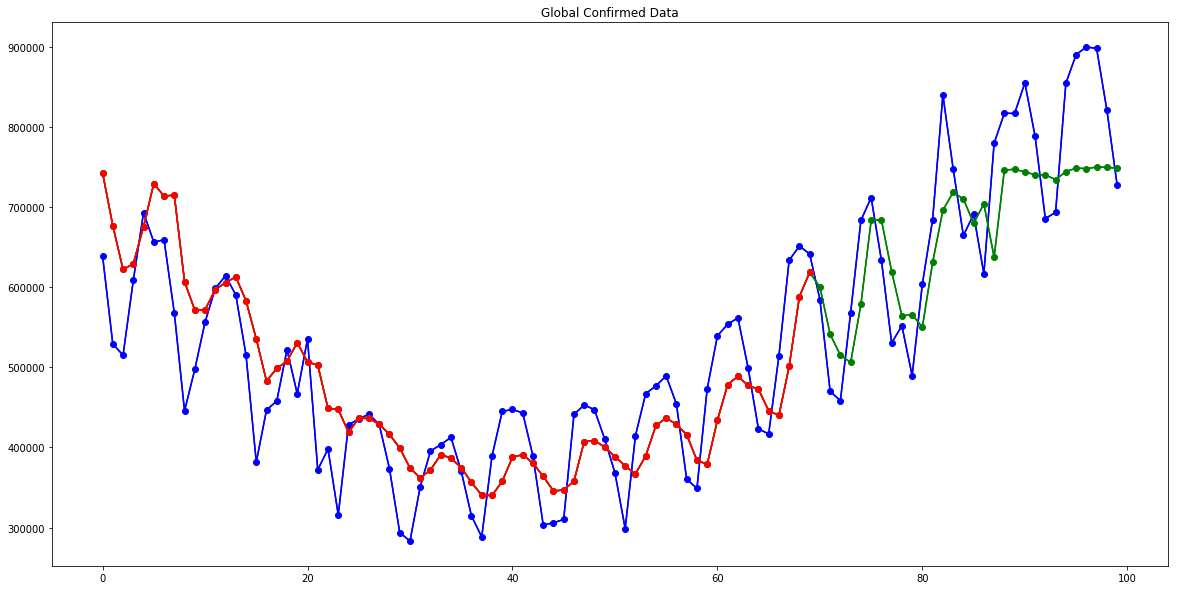

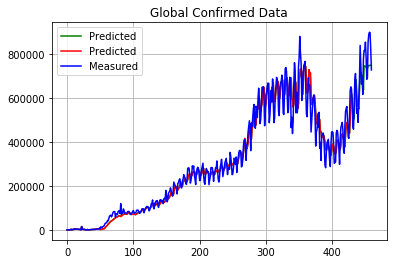

-----------------------------------------------------------------------------------------
| end of epoch 200 | time:  3.35s | mse loss 0.12266 | rmsle loss 0.13356 
-----------------------------------------------------------------------------------------


In [33]:
dealData = DealData("/home/soul/NewWorkSpace/Covid_2021_4_18/data/global.csv")
train_data, val_data = dealData.trainTestData()
# train_data = dealData.train_data()
model = TransAm().to(device)

criterion = nn.MSELoss()
lr = 0.005 
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

best_val_loss = float("inf")
epochs = 200 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data)

    if(epoch % 10 is 0):
#         mse, rmsle, truth, test_result = dealData.get_plot_data(model)
#         plot_image(truth, test_result)
        mse, rmsle = dealData.plot_and_loss(model, epoch, True)
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | mse loss {:5.5f} | rmsle loss {:5.5f} '.format(epoch, (time.time() - epoch_start_time),
                                         mse, rmsle))
        print('-' * 89)

    scheduler.step() 
#     saveModel(model, "parameter_global_confirmed_50sq_del30_changeLoss_noise_" + str(i) + "_best") 

In [30]:
saveModel(model, "parameter_global_confirmed_50sq_del30_NoGan_best_everyday") 

# Load Model

460 460
mse:  0.13986704
rmsle:  0.15155727
mae:  0.3144452
mape:  0.23136629
rmse:  0.37398803


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



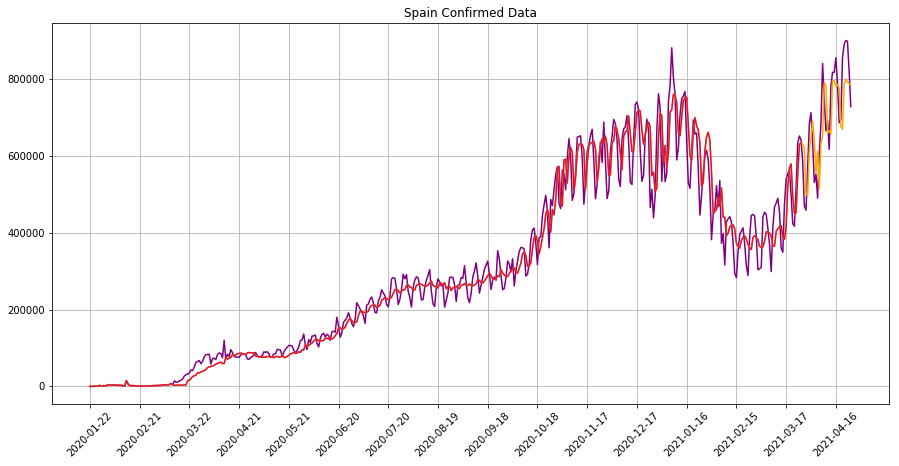

In [35]:
pmodel = TransAm().to(device)
pmodel = loadModel(pmodel, "parameter_global_confirmed_50sq_del30_noise_best_everyday")
dealData = DealData("/home/soul/NewWorkSpace/Covid_2021_4_18/data/global.csv",
                        "/home/soul/NewWorkSpace/Covid_2021_4_18/ganDataNew/stand_global_del30_confirmed_SJ_noise_1000_everyday.npy")
df = pd.read_csv("/home/soul/NewWorkSpace/Covid_2021_4_18/data/global.csv")
mse, rmsle, mae, mape, rmse, truth, test_result = dealData.get_plot_data(pmodel)
print("mse: ", mse)
print("rmsle: ", rmsle)
print("mae: ", mae)
print("mape: ", mape)
print("rmse: ", rmse)
plot_image(truth, test_result, start = df.date[0], end = df.date[df.shape[0]-1], title = 'Spain Confirmed Data', isSave = True)

460 460
mse:  0.116622284
rmsle:  0.1352534
mae:  0.28296223
mape:  0.19939594
rmse:  0.34150004


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



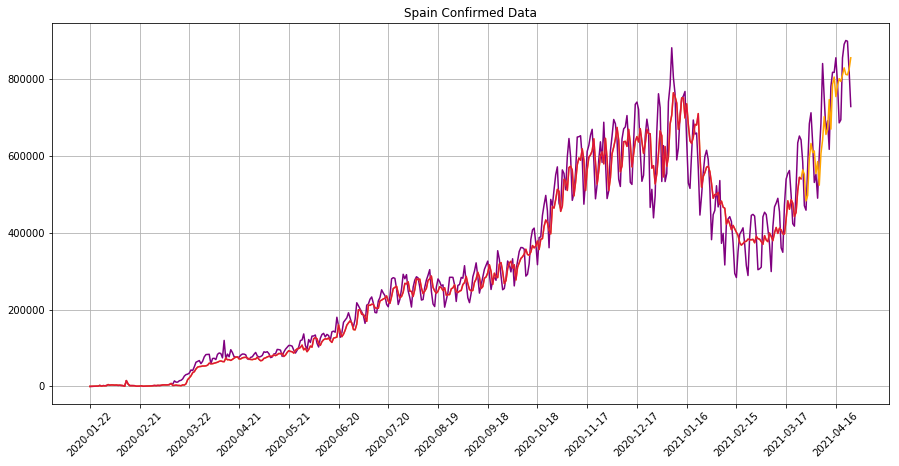

In [36]:
pmodel = TransAm().to(device)
pmodel = loadModel(pmodel, "parameter_global_confirmed_50sq_del30_SJ_best_everyday")
dealData = DealData("/home/soul/NewWorkSpace/Covid_2021_4_18/data/global.csv",
                        "/home/soul/NewWorkSpace/Covid_2021_4_18/ganDataNew/stand_global_del30_confirmed_SJ_noise_1000_everyday.npy")
df = pd.read_csv("/home/soul/NewWorkSpace/Covid_2021_4_18/data/global.csv")
mse, rmsle, mae, mape, rmse, truth, test_result = dealData.get_plot_data(pmodel)
print("mse: ", mse)
print("rmsle: ", rmsle)
print("mae: ", mae)
print("mape: ", mape)
print("rmse: ", rmse)
plot_image(truth, test_result, start = df.date[0], end = df.date[df.shape[0]-1], title = 'Spain Confirmed Data', isSave = True)

460 460
mse:  0.15205194
rmsle:  0.15026234
mae:  0.32773414
mape:  0.21799569
rmse:  0.38993838


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



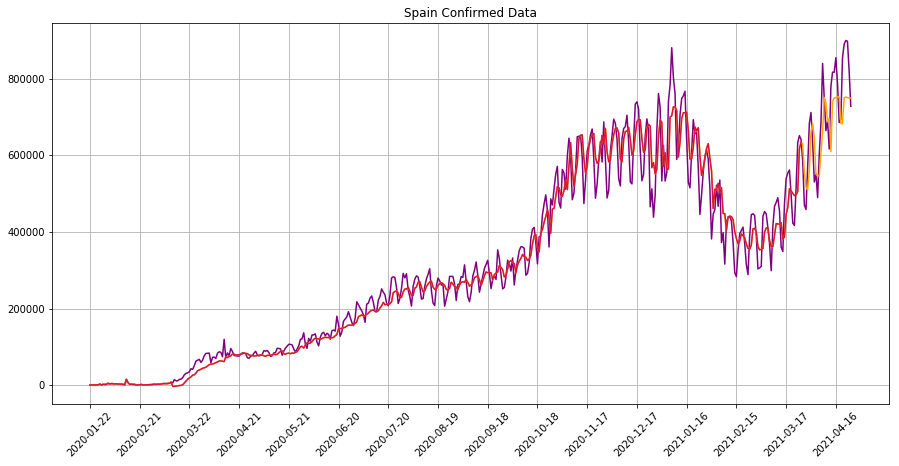

In [37]:
pmodel = TransAm().to(device)
pmodel = loadModel(pmodel, "parameter_global_confirmed_50sq_del30_NoGan_best_everyday")
dealData = DealData("/home/soul/NewWorkSpace/Covid_2021_4_18/data/global.csv")
df = pd.read_csv("/home/soul/NewWorkSpace/Covid_2021_4_18/data/global.csv")
mse, rmsle, mae, mape, rmse, truth, test_result = dealData.get_plot_data(pmodel)
print("mse: ", mse)
print("rmsle: ", rmsle)
print("mae: ", mae)
print("mape: ", mape)
print("rmse: ", rmse)
plot_image(truth, test_result, start = df.date[0], end = df.date[df.shape[0]-1], title = 'Spain Confirmed Data', isSave = True)